# This notebook contains the code necessary for producing the results shown in the datastory.

### **Pipeline used for different tasks**
- Bart classification into labels : pipeline_bart_classification.ipynb
- Keyword Search :                  keyword_search.ipynb, keyword_qualty_control.ipynb
- Country scraping :                country_scraping.ipynb
- Data cleaning :                   clean_data.ipynb
- Data extraction :                 chunk_extraction_metadata.ipynb

**Country Scraping**

We performed country scraping trough the youtube API but also trough a Webarchive of socialblade, this proved to be quite long and the full pipeline can be found under pipelines/country_scraping.ipynb. For the categorisation special values are 'deleted' - channels for which the youtube API did not have any info anymore, 'no_country' - channels with no info on youtube and no country indicated on the webarchive, 'no_rec' - channels with no info on youtube and no record on the archive. We report here the results of the scraping:

**Keyword Search**

Since BART proved to be too long and Bert not reliable enough, keyword search was implemented to categorise the data. We used a human and bottom up approach, aiming to categorise spam videos first then big observed big categories, then the rest of the data in an order that makes sense semantically, since categorised videos are no longer considered for further categorisation. The order of classification is thus important, even crucial. Since looking for single expressions is way faster than fancy regexp combinations we pay particular attention to chosen words, for them not to be too general and warn of high frequency words in nltk word frequency distributions. We used personal knowledge, chatGPT, the web, youtube, twitch and copilot to curate the lists of expressions for the categories. This was an iterative process and included a quality control step to further refine the quality of the classification, aiming to preferentially have smaller categories than lots of videos but wrongfully categorised. The categories can be found in config.py and the result is summarised here. 

In [ ]:
# Imports
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from scipy.stats import chisquare
import seaborn as sns
import statsmodels.api as sm
import matplotlib.ticker as mtick
from datetime import datetime
import os
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit
from plotly.subplots import make_subplots
from causality import *
from country_scraping import agglomerate_countries
from config import *
import sys
import os.path as op
sys.path.insert(0, '.') # project folder
from country_analysis import get_region, custom_color_map, get_country_fullname

pio.renderers.default = 'browser'  # Opens the plot in your default web browser

## How you became smarter or how has the volume of educational content changed over time ?

In [ ]:
# Get data
path = './data/raw'
df = pd.DataFrame()

for i in range(8):
    new_df = pd.read_csv(path+f'/Education_videos_{i}_cleaned.csv')
    new_df = new_df.dropna(axis=0)
    df = pd.concat([df, new_df])
    del(new_df)
    print(f'Imported Education_videos_{i}_cleaned.csv')

df['upload_date'] = pd.to_datetime(df['upload_date'])
df['year'] = df['upload_date'].dt.year
df['month'] = df['upload_date'].dt.month

classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(lambda x: ast.literal_eval(x))
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['year'] = classified['upload_date'].dt.year
classified['month'] = classified['upload_date'].dt.month

Imported Education_videos_0_cleaned.csv
Imported Education_videos_1_cleaned.csv
Imported Education_videos_2_cleaned.csv
Imported Education_videos_3_cleaned.csv
Imported Education_videos_4_cleaned.csv
Imported Education_videos_5_cleaned.csv
Imported Education_videos_6_cleaned.csv
Imported Education_videos_7_cleaned.csv


### Checking representativeness

16.285601063032317 0.2962458949870938


C:\Users\fpili\AppData\Local\Temp\ipykernel_19696\528801815.py:18: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



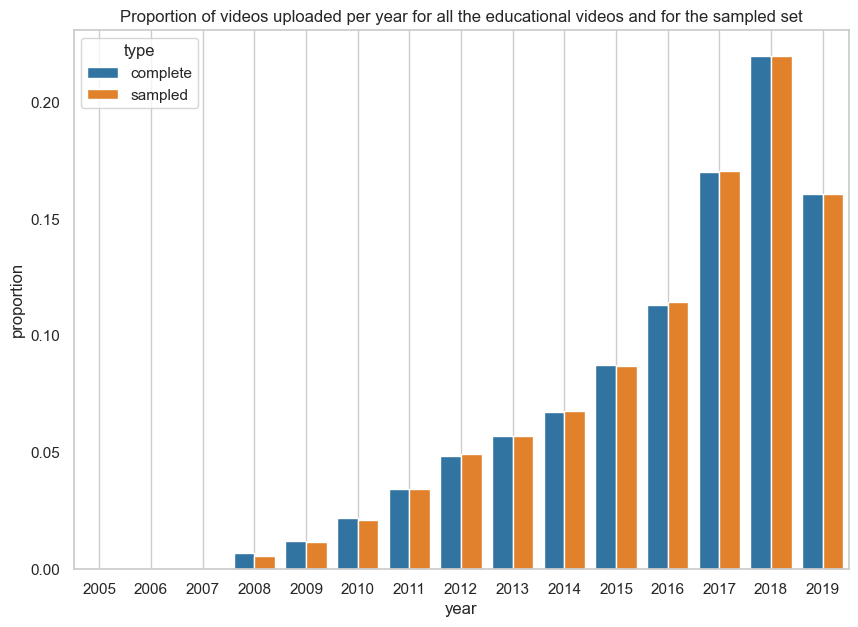

In [ ]:
# Proportions
classified_proportions = (classified.groupby('year').size()/len(classified)).reset_index(name='proportion')
original_proportions = (df.groupby('year').size()/len(df)).reset_index(name='proportion')
original_proportions['type'] = 'complete'
classified_proportions['type'] = 'sampled'
proportions_df = pd.concat([original_proportions, classified_proportions])

# Chisquare goodness of fit
sampled = classified.groupby('year').size()
complete = df.groupby('year').size()
complete = complete * (sampled.sum() / complete.sum())
chi_stat, p_value = chisquare(f_obs=sampled, f_exp=complete)
print(chi_stat, p_value)

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,7))
palette = sns.color_palette("tab10")
sns.barplot(data=proportions_df, x='year', y='proportion', hue='type', ax=ax, palette=palette)
ax.grid()
ax.set_title('Proportion of videos uploaded per year for all the educational videos and for the sampled set')
plt.savefig(f"./data/figures/hybs/comparison_proportion_video_uploaded_year.png")
plt.show()

# Plotly
# Merge the proportions into a single DataFrame
proportions_df = pd.DataFrame({
    'year': classified_proportions.index,
    'sample_dataset': classified_proportions['proportion'],
    'whole_dataset': original_proportions['proportion']
})

# Create the grouped bar chart
fig = go.Figure()
fig.add_trace(go.Bar(
    x=proportions_df['year'],
    y=proportions_df['sample_dataset'],
    name='Sample Dataset'
))
fig.add_trace(go.Bar(
    x=proportions_df['year'],
    y=proportions_df['whole_dataset'],
    name='Whole Dataset'
))

# Update layout for better visualization
fig.update_layout(
    title='Proportion of videos uploaded per year for all the educational videos and for the sampled set',
    xaxis_title='Year',
    yaxis_title='Proportion',
    barmode='group',  # Side-by-side bars
    legend_title='Dataset',
        xaxis=dict(
        tickmode='linear',
        dtick=1
    ),
    title_x = 0.5,
)
fig.write_html(f"./data/figures/hybs/comparison_proportion_video_uploaded_year.html")
# fig.show()

> Cannot reject null hypothesis that the two distribution have the same frequencies

14.488299611094055 0.20714103096036054


C:\Users\fpili\AppData\Local\Temp\ipykernel_19696\226191677.py:18: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



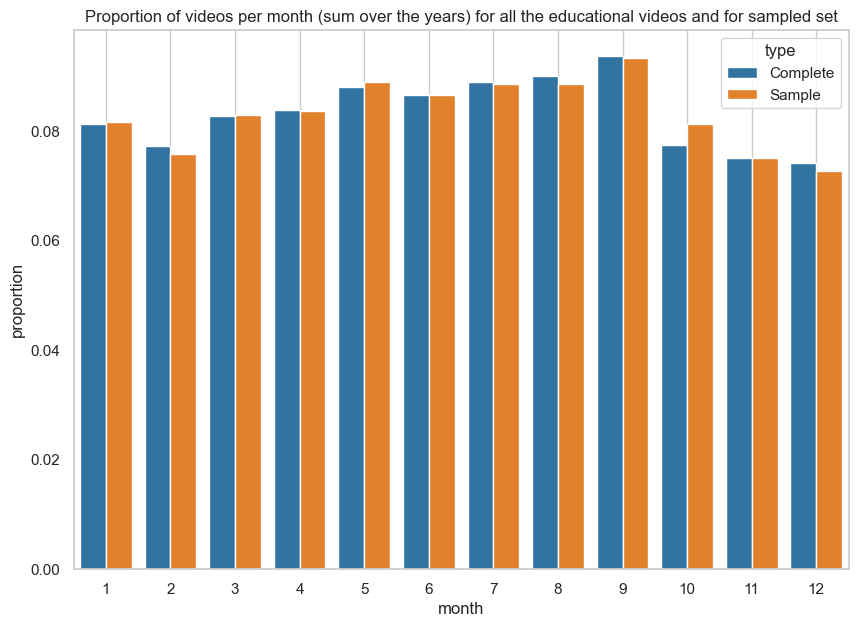

In [ ]:
# Proportions
classified_proportion = (classified.groupby('month').size()/len(classified)).reset_index(name='proportion')
original_proportion = (df.groupby('month').size()/len(df)).reset_index(name='proportion')
classified_proportion['type'] = 'Sample'
original_proportion['type'] = 'Complete'
proportions_df = pd.concat([original_proportion, classified_proportion])

# Chisquare goodness of fit
sampled = classified.groupby('month').size()
complete = df.groupby('month').size()
complete = complete * (sampled.sum() / complete.sum())
chi_stat, p_value = chisquare(f_obs=sampled, f_exp=complete)
print(chi_stat, p_value)

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,7))
palette = sns.color_palette("tab10")
sns.barplot(data=proportions_df, x='month', y='proportion', hue='type', ax=ax, palette=palette)
ax.set_title('Proportion of videos per month (sum over the years) for all the educational videos and for sampled set')
ax.grid()
plt.savefig(f"./data/figures/hybs/comparison_proportion_video_uploaded_month.png")

# Plotly
# Merge the proportions into a single DataFrame
proportions_df = pd.DataFrame({
    'month': classified_proportion.index + 1,
    'sample_dataset': classified_proportion['proportion'],
    'whole_dataset': original_proportion['proportion']
})

# Create the grouped bar chart
fig = go.Figure()
fig.add_trace(go.Bar(
    x=proportions_df['month'],
    y=proportions_df['sample_dataset'],
    name='Sample Dataset'
))
fig.add_trace(go.Bar(
    x=proportions_df['month'],
    y=proportions_df['whole_dataset'],
    name='Whole Dataset'
))

# Update layout for better visualization
fig.update_layout(
    title='Proportion of videos per month (sum over the years) for all the educational videos and for sampled set',
    xaxis_title='Month',
    yaxis_title='Proportion',
    barmode='group',  # Side-by-side bars
    legend_title='Dataset',
        xaxis=dict(
        tickmode='linear',
        dtick=1
    ),
    title_x = 0.5,
)
fig.write_html(f"./data/figures/hybs/comparison_proportion_video_uploaded_month.html")
# fig.show()

> Cannot reject null hypothesis that the two distribution have the same frequencies

### Categories across years


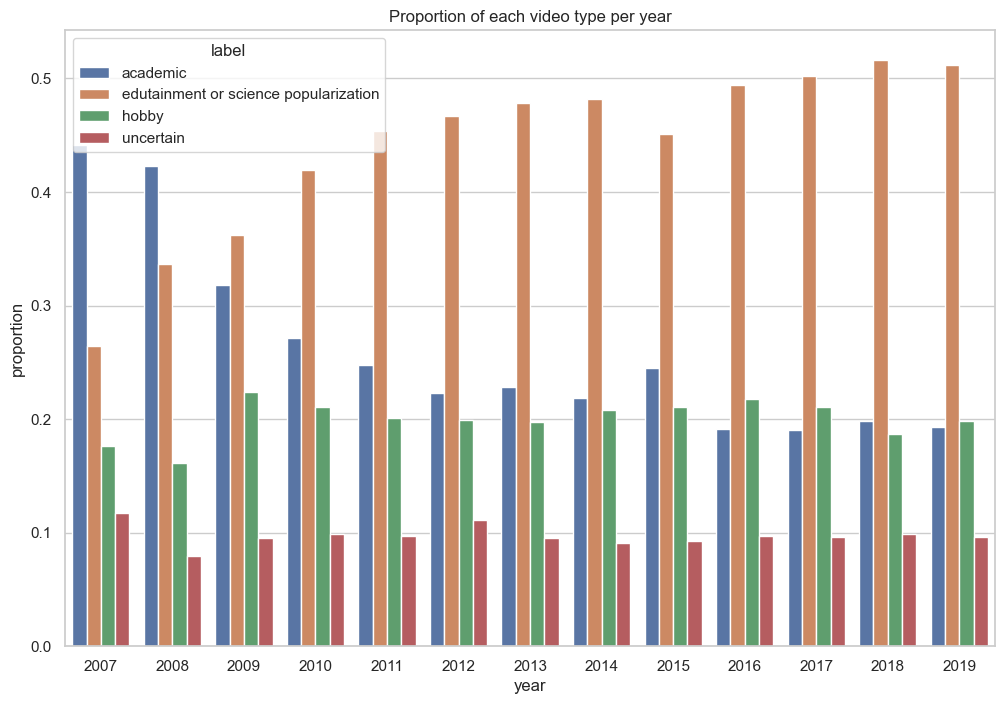

In [ ]:
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
# Remove 2005, 2006, as the number of videos is too low to make any statistical analysis
years = np.arange(2007, 2020)
classified = classified[classified['year'].isin(years)]

# Compute proportion per year for each label
count_per_year_label = classified.groupby(['year', 'label']).size().unstack(fill_value=0)
proportion_per_year = count_per_year_label.div(count_per_year_label.sum(axis=1), axis=0)

# Convert for easier plot
proportion_long = proportion_per_year.reset_index().melt(id_vars='year', value_name='proportion', var_name='label')

# Plot
sns.set_theme(style="whitegrid")
palette = sns.color_palette("deep", 4)  # 4 distinct colors from the Set2 palette
fig, ax = plt.subplots(1,1, figsize=(12,8))

sns.barplot(data=proportion_long, x='year', y='proportion', hue='label', ax=ax, palette=palette)
ax.set_title('Proportion of each video type per year')
plt.savefig("./data/figures/hybs/proportion_video_type_per_year.png")
plt.show()


# Plotly
fig_plotly = px.bar(
    proportion_long,
    x='year',
    y='proportion',
    color='label',
    title='Proportion of Each Video Type per Year',
    labels={'proportion': 'Proportion', 'year': 'Year', 'label': 'Video Type'},
    color_discrete_sequence=px.colors.qualitative.Dark2
)

fig_plotly.update_layout(
    barmode='group',  # Side-by-side bars
    xaxis=dict(
        tickmode='linear',
        dtick=1
    ),
    yaxis_title='Proportion',
    legend_title='Video Type',
    title_x=0.5,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=1.02,  # Position above the plot
        xanchor="center",
        x=0.5
    )
)

# Show Plotly plot
fig_plotly.write_html(f"./data/figures/hybs/proportion_video_type_per_year.html")
# fig_plotly.show()


> We can observe a decline of the academic videos for the benefit of edutainment videos.

> There is a noticable increase of edutainment videos from 2008 to 2013, suggesting that edutainment became popular in the early years of youtube.
> The early rise in popularity could reflect the novelty of the platform and the unmet demand for accessible educational content.
> The slower growth in later years might suggest a maturation of the YouTube ecosystem, where edutainment became an established genre.

> We see that academic videos became less and less popular reaching a plateau at around 2011, reaching a plateau. We could argue that youtube introduced a new type of educational content that is easier to consume and fits YouTube’s informal and entertainment-focused culture better.

> The transition from academic to edutainment content reflects changing consumer preferences. Viewers on YouTube may prefer content that simplifies complex topics, incorporates storytelling, and uses visuals and humor to maintain engagement.

#### OLS

In [ ]:
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
# Remove 2005, 2006 as the number of videos is too low to make any statistical analysis
years = np.arange(2007, 2020)
classified = classified[classified['year'].isin(years)]

# Compute proportion per year for each label
count_per_year_label = classified.groupby(['year', 'label']).size().unstack(fill_value=0)
proportion_per_year = count_per_year_label.div(count_per_year_label.sum(axis=1), axis=0).reset_index()

X = proportion_per_year['year']
X = sm.add_constant(X)

# Academic
Y = proportion_per_year['academic']
model_academic = sm.OLS(Y, X).fit()
print('Academic')
print(model_academic.summary())

# Edutainment
Y = proportion_per_year['edutainment or science popularization']
model_edutainment = sm.OLS(Y, X).fit()
print('Edutainment')
print(model_edutainment.summary())

# Hobby
Y = proportion_per_year['hobby']
model_hobby = sm.OLS(Y, X).fit()
print('Hobby')
print(model_hobby.summary())

Academic
                            OLS Regression Results                            
Dep. Variable:               academic   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     30.20
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           0.000188
Time:                        14:14:07   Log-Likelihood:                 22.828
No. Observations:                  13   AIC:                            -41.66
Df Residuals:                      11   BIC:                            -40.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5186      6.780      5.534

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.



> Academic : R² = 0.733, pvalue = 0.000188, statistic relationship between year and proportion of academic videos

> Edutainment : R² = 0.792, pvalue = 4.63e-05, statistic relationship between year and proportion of edutainment videos

> hobby : R² = 0.100, pvalue = 0.292, no statistical relationship between year and proportion of hobby videos

### Education content over time

In [ ]:
# Get data
df_vd = pd.read_feather("./data/raw/yt_metadata_helper.feather")

In [ ]:
# Convert to datetime
df_vd['upload_date'] = pd.to_datetime(df_vd['upload_date'])
df_vd['year'] = df_vd['upload_date'].dt.year

#### Education videos over time

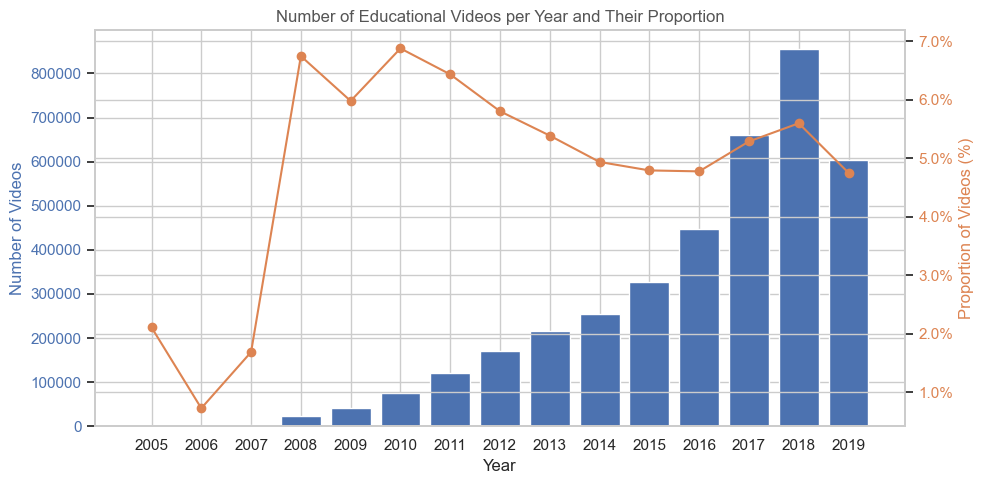

In [ ]:
colors = sns.color_palette("deep")
bar_color = colors[0]    # for bars
line_color = colors[1]   # for line

number_per_year = df_vd[df_vd['categories'] == 'Education'].groupby('year').size()
total_videos_per_year = df_vd.groupby('year').size()
proportion_per_year = number_per_year.div(total_videos_per_year) * 100  # Convert to percentages

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bar chart
ax.bar(number_per_year.index, number_per_year.values, color=bar_color, width=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Videos', color=bar_color)
ax.set_xticks(number_per_year.index)
ax.tick_params(axis='y', labelcolor=bar_color)

# Create a twin axis for the percentages
ax2 = ax.twinx()
ax2.plot(proportion_per_year.index, proportion_per_year.values, 
         color=line_color, marker='o', markerfacecolor=line_color, markeredgecolor=line_color)
ax2.set_ylabel('Proportion of Videos (%)', color=line_color)
ax2.tick_params(axis='y', labelcolor=line_color)

# Format the second y-axis to show the '%' sign
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Number of Educational Videos per Year and Their Proportion', color='#555555')
plt.tight_layout()
plt.savefig('./data/figures/hybs/educational_videos_number_proportion_per_year.png')
plt.show()

# Create the Plotly figure
fig = go.Figure()
# Add the bar chart for the number of videos
fig.add_trace(go.Bar(
    x=number_per_year.index,
    y=number_per_year.values,
    name='Number of Videos',
    marker_color='rgb(31, 119, 180)',  # Deep blue color
    yaxis='y'  # Link to primary y-axis
))
# Add the line chart for the proportions
fig.add_trace(go.Scatter(
    x=proportion_per_year.index,
    y=proportion_per_year.values,
    name='Proportion of Videos',
    mode='lines+markers',
    line=dict(color='rgb(255, 127, 14)', width=2),  # Deep orange line
    marker=dict(size=8, color='rgb(255, 127, 14)'),
    yaxis='y2'  # Link to secondary y-axis
))
# Customize the layout
fig.update_layout(
    title='Number of Educational Videos per Year and Their Proportion',
    title_x=0.5,
    xaxis=dict(
        title='Year'
    ),
    yaxis=dict(
        title=dict(
            text='Number of Videos',
            font=dict(color='rgb(31, 119, 180)')
        ),
        tickfont=dict(color='rgb(31, 119, 180)')
    ),
    yaxis2=dict(
        title=dict(
            text='Proportion of Videos (%)',  # Add percentage symbol in the title
            font=dict(color='rgb(255, 127, 14)')
        ),
        tickfont=dict(color='rgb(255, 127, 14)'),
        overlaying='y',  # Overlay second y-axis
        side='right',  # Place second axis on the right side
        tickformat='.2f',  # Keep the fraction as-is, e.g., 0.25 instead of 25%
    ),
    legend=dict(
        title='Metric',
        x=0.5,
        xanchor='center',
        orientation='h'
    ),
    template='plotly_white'
)
# Show the plot
fig.write_html('./data/figures/hybs/educational_videos_number_proportion_per_year.html')
# fig.show()

#### OLS (starting from 2008)

In [ ]:
# Only look after 2008 as it is the point from which the proportion decreases
years_to_use = np.arange(2008, 2020)
df_vd_filtered = df_vd[df_vd['year'].isin(years_to_use)]

number_per_year = df_vd_filtered[df_vd_filtered['categories'] == 'Education'].groupby('year').size()
total_videos_per_year = df_vd_filtered.groupby('year').size()
proportion_per_year = number_per_year.div(total_videos_per_year) * 100  # Convert to percentages

X = years_to_use
X = sm.add_constant(X)
Y = proportion_per_year

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     17.10
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00203
Time:                        14:19:01   Log-Likelihood:                -7.3302
No. Observations:                  12   AIC:                             18.66
Df Residuals:                      10   BIC:                             19.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        345.5489     82.210      4.203      0.0

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.



> R² = 0.631, pvalue = 0.00203, 63.1 % of variation explained by the model, relatively good fit, statistically significant model, the year has a significant effect on the proportion of academic videos. Slope = -0.1688 meaning that according to this linear model, each years shows 0.1688 % less academic videos than the preceding year

#### Education channels over time

In [ ]:
df_ch = pd.read_csv("./data/raw/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_ch = df_ch.dropna()
df_ch["join_date"] = pd.to_datetime(df_ch["join_date"])
df_ch['year'] = df_ch['join_date'].dt.year.astype(int)

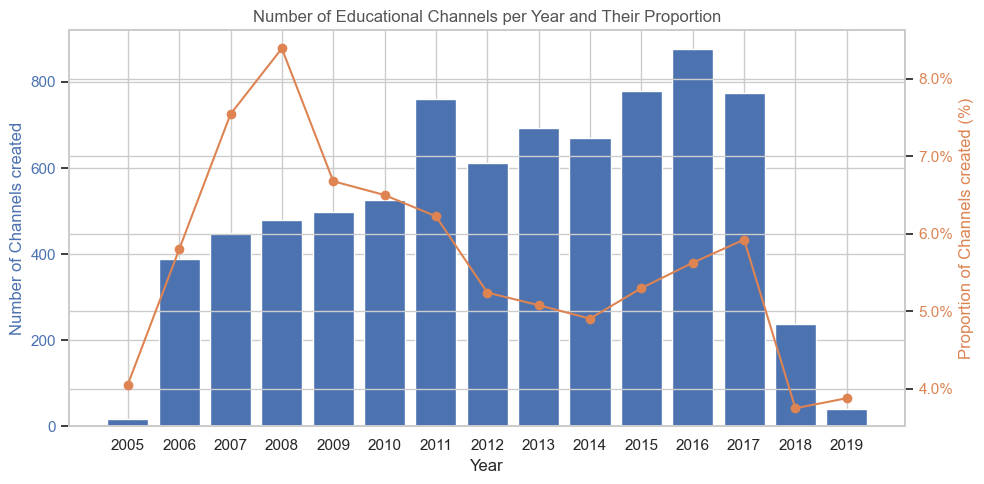

In [ ]:
number_education_per_year = df_ch[df_ch['category_cc'] == 'Education'].groupby('year').size()
total_channel_per_year = df_ch.groupby('year').size()
proportion_per_year = number_education_per_year.div(total_channel_per_year) * 100

colors = sns.color_palette("deep")
bar_color = colors[0]    # for bars
line_color = colors[1]   # for line

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bar chart
ax.bar(number_education_per_year.index, number_education_per_year.values, color=bar_color, width=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Channels created', color=bar_color)
ax.set_xticks(number_education_per_year.index)
ax.tick_params(axis='y', labelcolor=bar_color)

# Create a twin axis for the percentages
ax2 = ax.twinx()
ax2.plot(proportion_per_year.index, proportion_per_year.values, 
         color=line_color, marker='o', markerfacecolor=line_color, markeredgecolor=line_color)
ax2.set_ylabel('Proportion of Channels created (%)', color=line_color)
ax2.tick_params(axis='y', labelcolor=line_color)

# Format the second y-axis to show the '%' sign
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Number of Educational Channels per Year and Their Proportion', color='#555555')
plt.tight_layout()
plt.savefig("./data/figures/hybs/educational_channel_number_proportion_per_year.png")
plt.show()

# Create the Plotly figure
fig = go.Figure()
# Add the bar chart for the number of videos
fig.add_trace(go.Bar(
    x=number_education_per_year.index,
    y=number_education_per_year.values,
    name='Number of Videos',
    marker_color='rgb(31, 119, 180)',  # Deep blue color
    yaxis='y'  # Link to primary y-axis
))
# Add the line chart for the proportions
fig.add_trace(go.Scatter(
    x=proportion_per_year.index,
    y=proportion_per_year.values,
    name='Proportion of Videos',
    mode='lines+markers',
    line=dict(color='rgb(255, 127, 14)', width=2),  # Deep orange line
    marker=dict(size=8, color='rgb(255, 127, 14)'),
    yaxis='y2'  # Link to secondary y-axis
))
# Customize the layout
fig.update_layout(
    title='Number of Educational Videos per Year and Their Proportion',
    title_x=0.5,
    xaxis=dict(
        title='Year'
    ),
    yaxis=dict(
        title=dict(
            text='Number of Videos',
            font=dict(color='rgb(31, 119, 180)')
        ),
        tickfont=dict(color='rgb(31, 119, 180)')
    ),
    yaxis2=dict(
        title=dict(
            text='Proportion of Videos (%)',  # Add percentage symbol in the title
            font=dict(color='rgb(255, 127, 14)')
        ),
        tickfont=dict(color='rgb(255, 127, 14)'),
        overlaying='y',  # Overlay second y-axis
        side='right',  # Place second axis on the right side
        tickformat='.2f',  # Keep the fraction as-is, e.g., 0.25 instead of 25%
    ),
    legend=dict(
        title='Metric',
        x=0.5,
        xanchor='center',
        orientation='h'
    ),
    template='plotly_white'
)
# Show the plot
fig.write_html("./data/figures/hybs/educational_channel_number_proportion_per_year.html")
# fig.show()

#### OLS on proportion of channels created per year and number of channels created per year

In [ ]:
# Remove 2005, 2006, 2007, and 2019 only for the absolute number, not for proportion
df_ch = pd.read_csv("./data/raw/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_ch = df_ch.dropna()
df_ch["join_date"] = pd.to_datetime(df_ch["join_date"])
df_ch['year'] = df_ch['join_date'].dt.year.astype(int)

years_to_use_proportion = np.arange(2008, 2020)
years_to_use_count = np.arange(2008, 2019)

number_education_per_year = df_ch[df_ch['category_cc'] == 'Education'].groupby('year').size()
total_channel_per_year = df_ch.groupby('year').size()
proportion_per_year = number_education_per_year.div(total_channel_per_year) * 100

number_education_per_year = number_education_per_year.reset_index(name='count')
proportion_per_year = proportion_per_year.reset_index(name='proportion')

proportion_per_year = proportion_per_year[proportion_per_year['year'].isin(years_to_use_proportion)]
number_education_per_year = number_education_per_year[number_education_per_year['year'].isin(years_to_use_count)]

# OSL count
X = number_education_per_year['year']
X = sm.add_constant(X)
Y = number_education_per_year['count']
model_count = sm.OLS(Y, X).fit()
print('Number education channels created per year')
print(model_count.summary())

# OSL proportion
X = proportion_per_year['year']
X = sm.add_constant(X)
Y = proportion_per_year['proportion']
model_count = sm.OLS(Y, X).fit()
print('\nProportion education channels created per year')
print(model_count.summary())

Number education channels created per year
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.078
Method:                 Least Squares   F-statistic:                    0.2775
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.611
Time:                        14:20:06   Log-Likelihood:                -72.161
No. Observations:                  11   AIC:                             148.3
Df Residuals:                       9   BIC:                             149.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.

c:\Users\fpili\anaconda3\envs\ada2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.



> Number of channels created per year : R² = 0.03, the model is not statistically significant, but this is due to the year 2018 that has a very low amount of educational channels created.

> Proportion of educational channels created per year : R² = 0.684, pvalue = 0.000903. The model is statistically significant, with a slope of -0.29 meaning that each year has 0.29% less educational channels created than the previous year

# YouTube Wrapped [EDU EDITION] or are there spikes in educational content upload and consumption over the years?

In [ ]:
def load_metadata_videos(file_path):
    return pd.read_csv(file_path).drop(columns='Unnamed: 0').dropna()

### Pipeline to extract videos and google trends related to a certain topic

In [ ]:
def process_youtube_data(key_words, input_folder, output_file):
    """
    Filters videos by keywords and aggregates metrics by month.

    Args:
        key_words (list): List of keywords to search for in title and tags.

    Returns:
        pd.DataFrame: Aggregated data by month.
    """
    # Define the date range
    start_date = datetime(2008, 1, 1)
    end_date = datetime(2019, 9, 30)

    # Initialize an empty DataFrame for the final aggregated results
    aggregated_data = pd.DataFrame()

    # Process each file
    for i in range(0, 8):
        # Load the current CSV file
        file_name = f"Education_videos_{i}.csv"
        print('Processing file:', file_name)
        df_education = pd.read_csv(os.path.join(input_folder, file_name))
        print('###', df_education.shape[0], 'total videos')

        # Ensure upload_date is a datetime object
        df_education['upload_date'] = pd.to_datetime(df_education['upload_date'])

        # Filter videos by keywords in title or tags
        keyword_pattern = '|'.join(key_words)  # Create a regex pattern
        keyword_filter = (
            df_education['title'].str.contains(keyword_pattern, case=False, na=False) |
            df_education['tags'].str.contains(keyword_pattern, case=False, na=False)
        )
        filtered_df = df_education[keyword_filter]

        # Keep only videos within the date range
        filtered_df = filtered_df[(filtered_df['upload_date'] >= start_date) & (filtered_df['upload_date'] <= end_date)]
        print('###', filtered_df.shape[0], 'videos extracted')

        # Group by year and month
        filtered_df['year_month'] = filtered_df['upload_date'].dt.to_period('M')

        # print(filtered_df[(filtered_df['year_month'] == "2015-02") & (filtered_df['channel_id'] == "UCBVCi5JbYmfG3q5MEuoWdOw")].shape[0])

        # Aggregate metrics
        monthly_data = filtered_df.groupby('year_month').agg(
            videos_count=('upload_date', 'count'),
            total_view_count=('view_count', 'sum'),
            total_dislike_count=('dislike_count', 'sum'),
            total_like_count=('like_count', 'sum'),
            total_duration=('duration', 'sum')
        ).reset_index()

        # Append to the final aggregated data
        aggregated_data = pd.concat([aggregated_data, monthly_data], ignore_index=True)

    # Combine data from all files by month
    aggregated_data = aggregated_data.groupby('year_month', as_index=False).agg(
        videos_count=('videos_count', 'sum'),
        total_view_count=('total_view_count', 'sum'),
        total_dislike_count=('total_dislike_count', 'sum'),
        total_like_count=('total_like_count', 'sum'),
        total_duration=('total_duration', 'sum')
    )

    # Convert year_month back to datetime for sorting
    aggregated_data['year_month'] = pd.to_datetime(aggregated_data['year_month'].astype(str)).dt.strftime('%Y-%m')
    aggregated_data = aggregated_data.sort_values(by='year_month')

    for k in key_words:
        google_trend_path = os.path.join(input_folder, "google_trends", f"{k}.csv") #change here to the folder containing the google trend files
        if not Path(google_trend_path).is_file(): continue
        df_gt = pd.read_csv(google_trend_path, skiprows=2, header=0, names=['year_month', k])
        df_gt[k] = df_gt[k]

        aggregated_data = pd.merge(
            df_gt,
            aggregated_data,
            on='year_month',
            how='left'
        ).fillna(0)

    # Save the result to a CSV file
    aggregated_data.to_csv(output_file, index=False)

    print(f"Data saved to {output_file}")

### Pipeline to produce the plots

In [ ]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

def exp_fit(col):

    def exponential_model(x, a, b):
        return a * np.exp(b * x)
    
    x = np.arange(col.shape[0])
    x = x / np.max(x)
    popt, pcov = curve_fit(exponential_model, x, col)
    a, b = popt
    y_fit = exponential_model(x, a, b)
    return y_fit

def trend_analysis(folder_path, key_words, config):

    file_path = os.path.join(folder_path, f"youtube_wrapped_{config['key']}.csv")
    df_wrapped = pd.read_csv(file_path)

    videos_count = normalize(df_wrapped['videos_count'])
    total_duration = normalize(df_wrapped['total_duration'])

    # Create the figure with subplots
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

    # Top subplot spanning the entire width: Content creation and trends
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f"{config['topic']} Popularity Over Time", fontsize=20)
    ax1.set_xlabel('Year-Month', fontsize=12)
    ax1.set_ylabel('Normalized Score', fontsize=12)
    ax1.set_ylim([-0.1, 1.1])

    # Plot videos count and total duration
    ax1.plot(df_wrapped['year_month'], videos_count, color='blue', label='Normalized Number of Videos', marker="o", linestyle='', markersize=5)
    ax1.plot(df_wrapped['year_month'], total_duration, color='blue', label='Normalized Total Duration', marker="^", linestyle='', markersize=5)

    if config['exp_fit']:
        ax1.plot(df_wrapped['year_month'], exp_fit(videos_count), color='blue', linestyle=':')
        ax1.plot(df_wrapped['year_month'], exp_fit(total_duration), color='blue', linestyle=':')

    ax1.set_xticks(df_wrapped['year_month'][::6])
    ax1.set_xticklabels(df_wrapped['year_month'][::6].astype(str), rotation=30, ha='right')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), title='--> Content creation scores')

    # Twin axis for Google Trends
    ax2 = ax1.twinx()
    ax2.set_ylim([-0.1, 1.1])

    markers = ['+', 'x', '3']
    i = 0
    correlation_variables = ['videos_count', 'total_duration']

    for k in key_words[config['key']]:
        if k not in df_wrapped.columns:
            continue
        df_wrapped[k] = df_wrapped[k].apply(lambda x: int(x) if (isinstance(x, str) and x.isdigit()) or isinstance(x, int) else 0)
        ax2.plot(df_wrapped['year_month'], df_wrapped[k] / 100, color='tab:red', label=k, marker=markers[i], linestyle='-', linewidth=0.3)
        i += 1
        correlation_variables.append(k)

    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.8), title='--> User interest scores')

    ax2.vlines(x=np.where(df_wrapped['year_month'] == '2017-08')[0][0], ymin=-1, ymax=2, colors='k', linestyles='--', linewidth=0.3)
    ax2.text(x=np.where(df_wrapped['year_month'] == '2017-08')[0][0] + 0.5, y=1.05, s='Google Trend update', color='grey')

    # Add annotations for events
    for event in config['events']:
        pos = 0.5 if event[2] == 'left' else -0.5
        ax2.vlines(x=np.where(df_wrapped['year_month'] == event[0])[0][0], ymin=-1, ymax=2, colors='k', linestyles='-', linewidth=1)
        ax2.text(x=np.where(df_wrapped['year_month'] == event[0])[0][0] + pos, y=-0.09, s=event[1], color='k', fontsize=15, horizontalalignment=event[2])

    # Bottom-left subplot: Seasonal decomposition
    if config['key'] == 'ML': df_wrapped.loc[85, "videos_count"] = (df_wrapped.loc[84, "videos_count"]+df_wrapped.loc[86, "videos_count"])/2 #remove outlier for seasonality analysis
    ax3 = fig.add_subplot(gs[1, 0])
    result = seasonal_decompose(df_wrapped['videos_count'], model='additive', period=12)
    ax3.plot(result.observed, label="Observed", color='blue')
    ax3.plot(result.trend, label="Trend", color='orange')
    ax3.plot(result.seasonal, label="Seasonal", color='green')
    ax3.set_title('Trend and Seasonality in the Number of Videos', fontsize=15)
    ax3.set_ylabel('Scores', fontsize=12)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_xticks(ticks=np.arange(0,140,12), labels=np.arange(2008, 2020), rotation=30, fontsize=10, ha='right')
    ax3.legend(loc='upper left')
    # Set y-limits based on the result data
    y_min = min(result.observed.min(), result.trend.min(), result.seasonal.min())
    y_max = max(result.observed.max(), result.trend.max(), result.seasonal.max())
    y_range = y_max-y_min
    ax3.set_ylim([y_min - 0.1*y_range, y_max + 0.1*y_range])

    # Add annotations for events
    for event in config['events']:
        ax3.vlines(x=np.where(df_wrapped['year_month'] == event[0])[0][0], ymin=-10000, ymax=10000, colors='k', linestyles='-', linewidth=1)

    # Bottom-right subplot: Correlation heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    correlation = df_wrapped[correlation_variables].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax4, annot_kws={'size': 13})
    ax4.set_title('Correlation Heatmap: Content Creation vs. Google Trends', fontsize=15)
    ax4.set_yticklabels(ax4.get_yticklabels(), rotation=30, fontsize=10, va='top')
    ax4.set_xticklabels(ax4.get_yticklabels(), rotation=30, fontsize=10, ha='right')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


### Variables

In [ ]:
key_words = {'ML': ['machine learning', 'deep learning', 'artificial intelligence'],
             'crypto': ['crypto', 'cryptocurrency', 'bitcoin', 'ethereum', 'binance'],
             'ebola': ['ebola'],
             'osama': ['bin laden', 'jihadi', 'al-qaeda'],
             'feminism': ['feminism', 'metoo', '#metoo', 'me too', 'gender equality', ' misoginy', 'toxic masculanity']}

configs = {'ML': {'key': 'ML',
                  'topic': 'Machine learning and AI',
                  'exp_fit': True,
                  'events': [('2012-09', 'AlexNet', 'left'), ('2016-03', 'AlphaGo', 'left')]},
           'crypto': {'key': 'crypto',
                      'topic': 'Cryptocurrency',
                      'exp_fit': False,
                      'events': [('2014-02', 'Mt. Gox Hack', 'left'), ('2017-01', 'Crypto Bubble', 'left')]},
           'ebola': {'key': 'ebola',
                     'topic': 'Ebola Disease',
                     'exp_fit': False,
                     'events': [('2013-12', 'Outbreak', 'right'), ('2014-08', 'Public Health Emergency', 'left')]},
           'osama': {'key': 'osama',
                     'topic': 'Bin Laden and Al-Qaeda',
                     'exp_fit': False,
                     'events': [('2011-05', 'Bin Laden Death', 'right'), ('2013-04', 'ISIS', 'left'), ('2015-01', 'Charlie Hebdo', 'left')]},
           'feminism': {'key': 'feminism',
                        'topic': 'Gender Equality and Feminism',
                        'exp_fit': True,
                        'events': [('2014-08', 'GamerGate', 'left'), ('2017-10', 'Weinstein', 'left')]}}

folder = r"C:\Users\Flori\Docs\Python\M2_S3_ADA\Project - data"

In [ ]:
key = 'ML' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
process_youtube_data(key_words=key_words['feminism'], input_folder=folder, output_file=output_file)

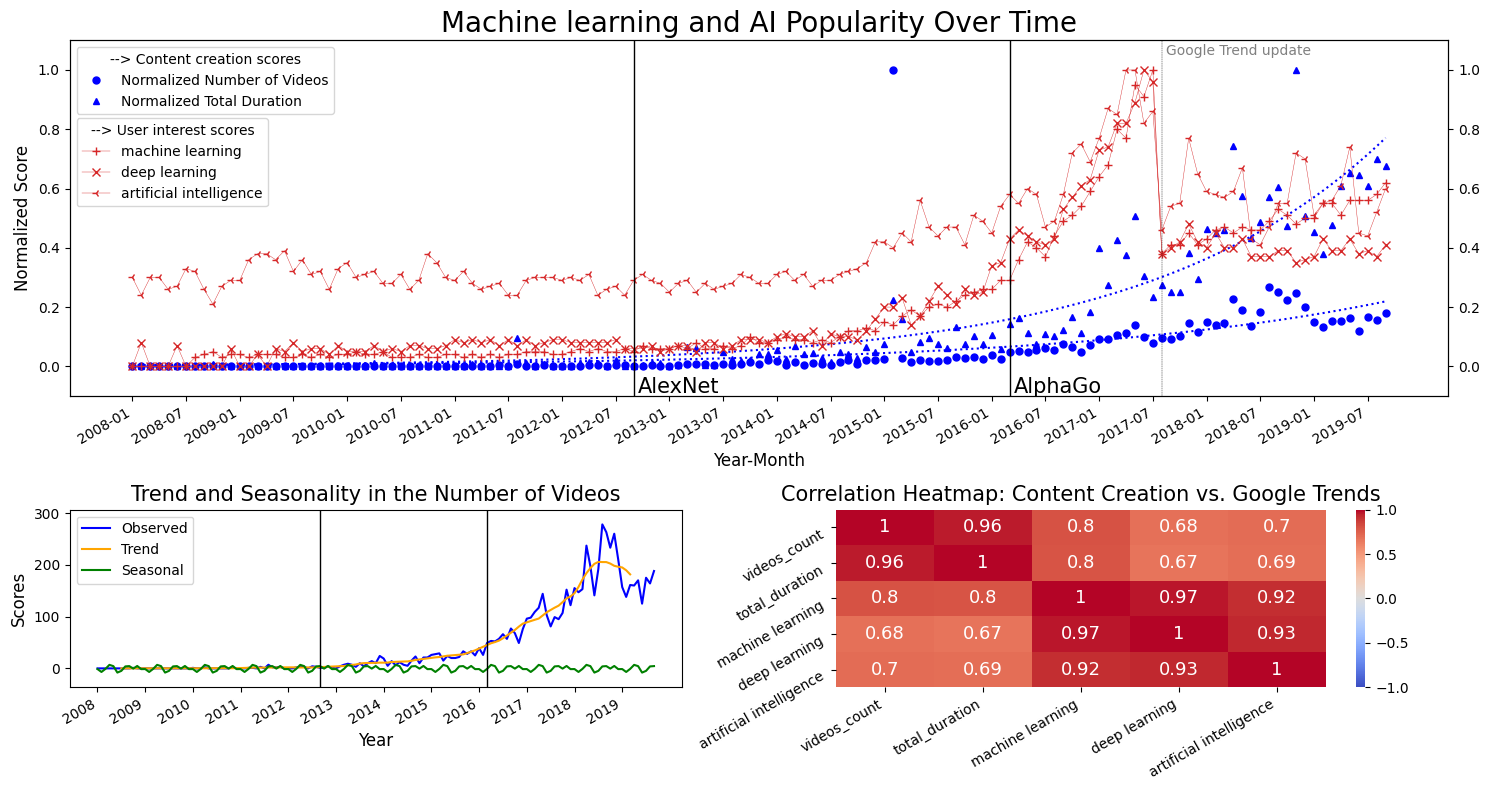

In [ ]:
key = 'ML' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

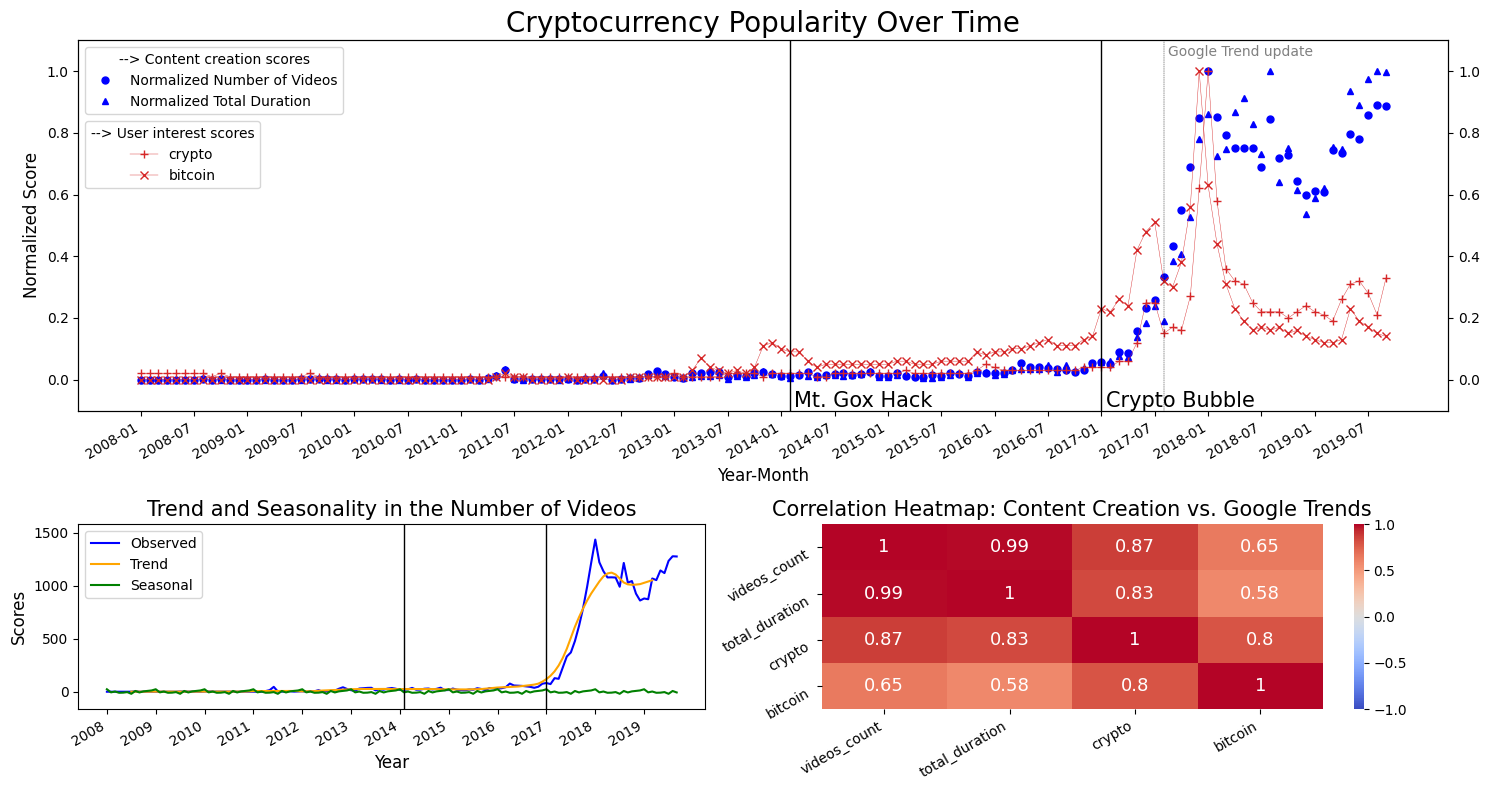

In [ ]:
key = 'crypto' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

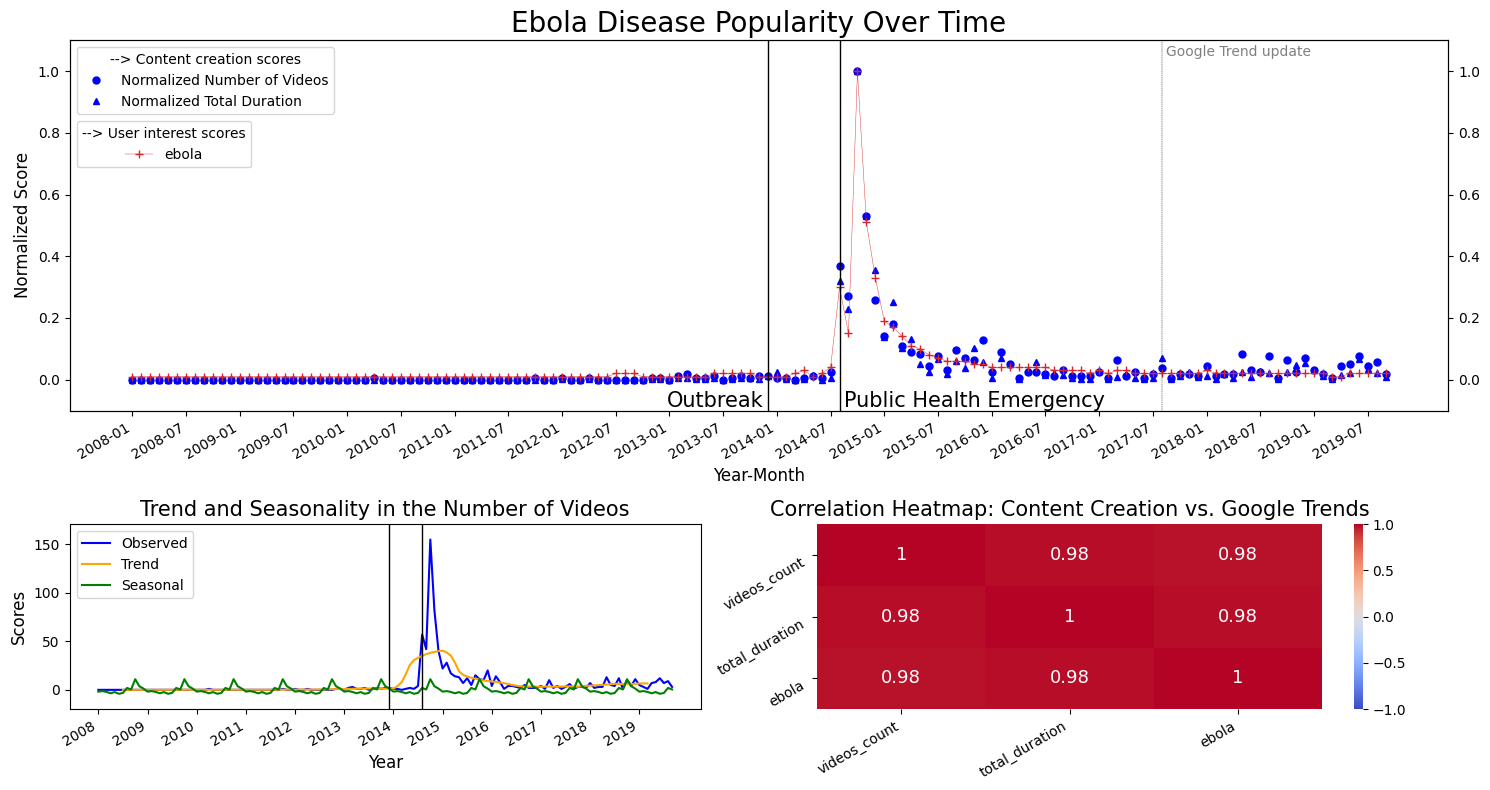

In [ ]:
key = 'ebola' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

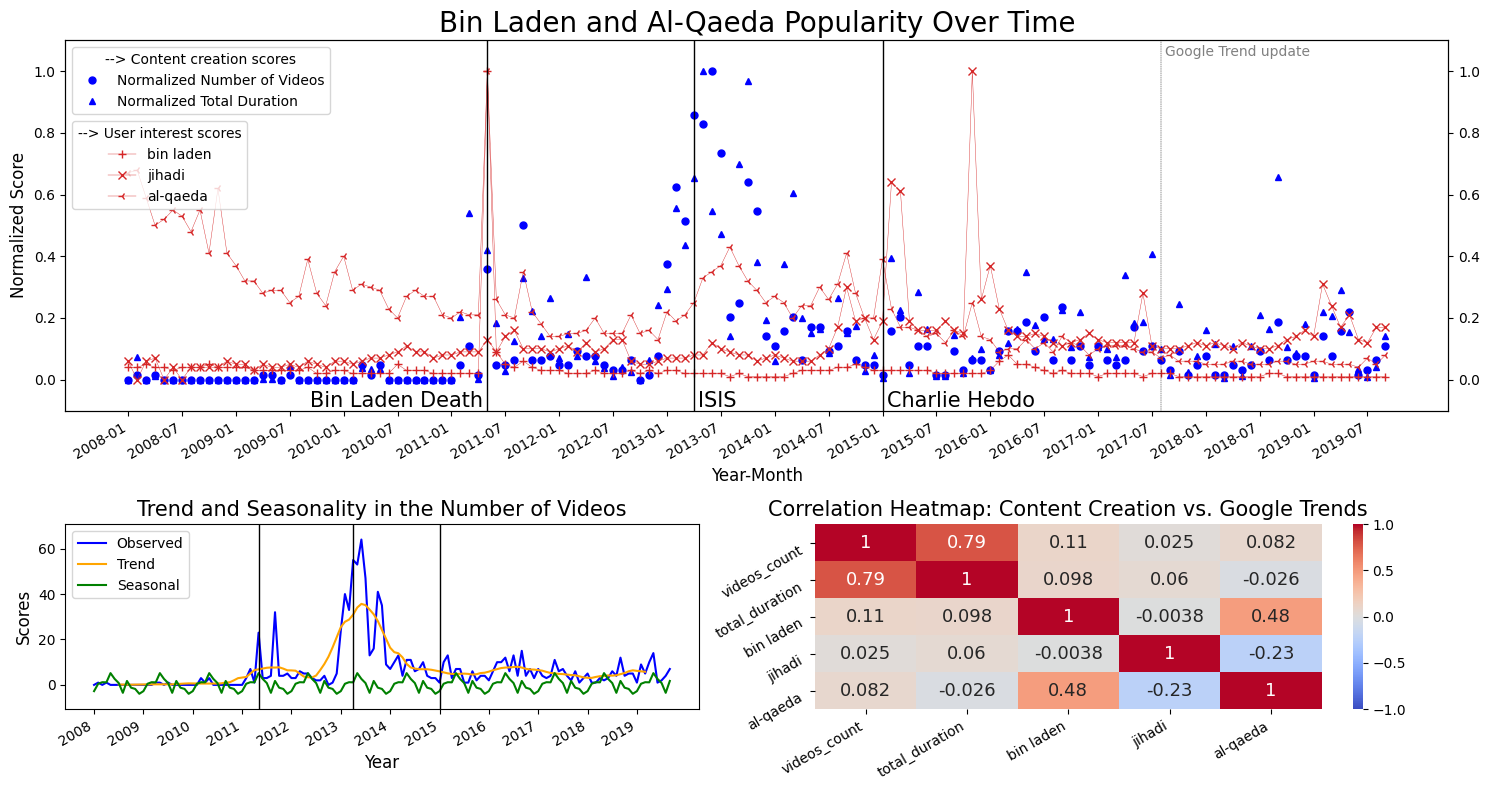

In [ ]:
key = 'osama' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

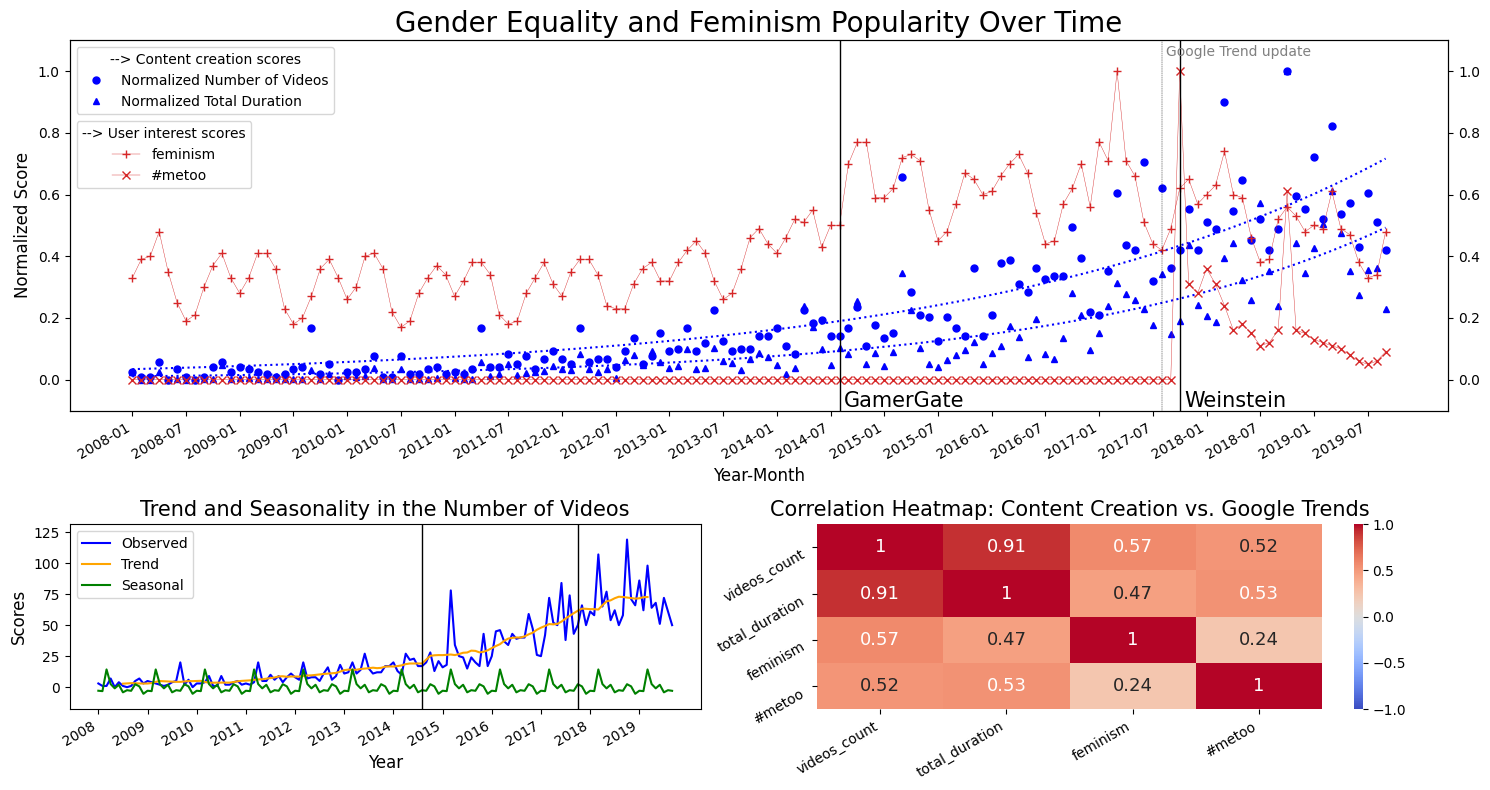

In [ ]:
key = 'feminism' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

## Y’all study last minute, and it shows… or are there specific times when educational content popularity spikes over the year?

### Academic videos

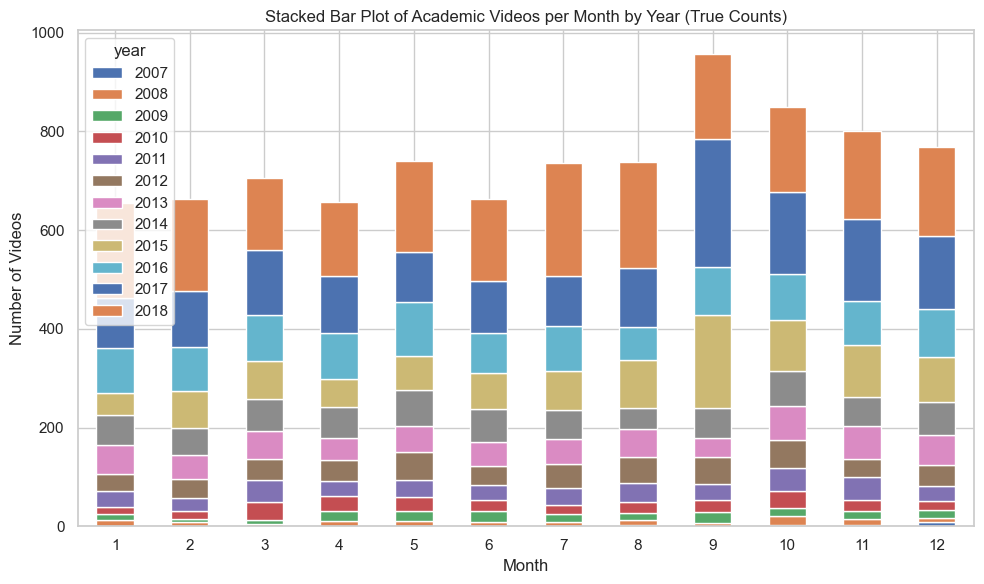

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2019 as the number of videos is too low to make any statistical analysis (year 2019 is not finished on the dataset)
years = np.arange(2007, 2019)
classified = classified[classified['year'].isin(years)]
academic = classified[classified['label'] == 'academic']

# Compute monthly count per year
monthly_counts = academic.groupby(['year', 'month']).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
monthly_counts.T.plot(
    kind='bar', 
    stacked=True, 
    ax=ax
)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Videos')
ax.set_title('Stacked Bar Plot of Academic Videos per Month by Year (True Counts)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("./data/figures/hybs/academic_videos_per_month_by_year.png")
plt.show()

# Plotly
# Reset the index and ensure 'month' is included
monthly_counts_reset = monthly_counts.T.reset_index().rename(columns={'index': 'month'})
# Convert the DataFrame to a long format for Plotly
monthly_counts_long = monthly_counts_reset.melt(id_vars='month', var_name='year', value_name='count')

# Plot with Plotly
fig_plotly = px.bar(
    monthly_counts_long,
    x='month',
    y='count',
    color='year',
    title='Stacked Bar Plot of Academic Videos per Month by Year (True Counts)',
    labels={'month': 'Month', 'count': 'Number of Videos', 'year': 'Year'},
    barmode='stack',
    color_discrete_sequence=px.colors.qualitative.Dark2,
)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_indices = list(range(1, 13))  # Assuming months are represented numerically as 1-12

# Update x-axis for month labels
fig_plotly.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=month_indices,
        ticktext=months,
        title='Month'
    ),
    yaxis_title='Number of Videos',
    legend_title='Year',
    title_x=0.5
)

fig_plotly.write_html(f"./data/figures/hybs/academic_videos_per_month_by_year.html")
# fig_plotly.show()

#### chi² with total sample distrib

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2019 as the number of videos is too low to make any statistical analysis (2019 is not finished in the dataset)
years = np.arange(2007, 2019)
classified = classified[classified['year'].isin(years)]

academic = classified[classified['label'] == 'academic']

# Remove non-complete years to avoid distortion
monthly_counts = academic.groupby('month').size()

# distribution for the whols sample
total = classified.groupby('month').size()
total_scaled = total * (monthly_counts.sum() / total.sum())


chi_stat, p_value = chisquare(f_obs=monthly_counts, f_exp=total_scaled)
print(chi_stat, p_value)


51.04200520476077 4.0627904907882806e-07


> p-value < 0.05, we can reject the null hypothesis

#### Which year is responsible for the divergence

Year: 2008, Chi-square Statistic: 10.81, p-value: 0.4591
Year: 2009, Chi-square Statistic: 14.36, p-value: 0.2138
Year: 2010, Chi-square Statistic: 22.63, p-value: 0.0199
Year: 2011, Chi-square Statistic: 9.20, p-value: 0.6036
Year: 2012, Chi-square Statistic: 9.35, p-value: 0.5896
Year: 2013, Chi-square Statistic: 13.33, p-value: 0.2723
Year: 2014, Chi-square Statistic: 13.16, p-value: 0.2830
Year: 2015, Chi-square Statistic: 129.13, p-value: 0.0000
Year: 2016, Chi-square Statistic: 16.23, p-value: 0.1330
Year: 2017, Chi-square Statistic: 130.80, p-value: 0.0000
Year: 2018, Chi-square Statistic: 45.68, p-value: 0.0000


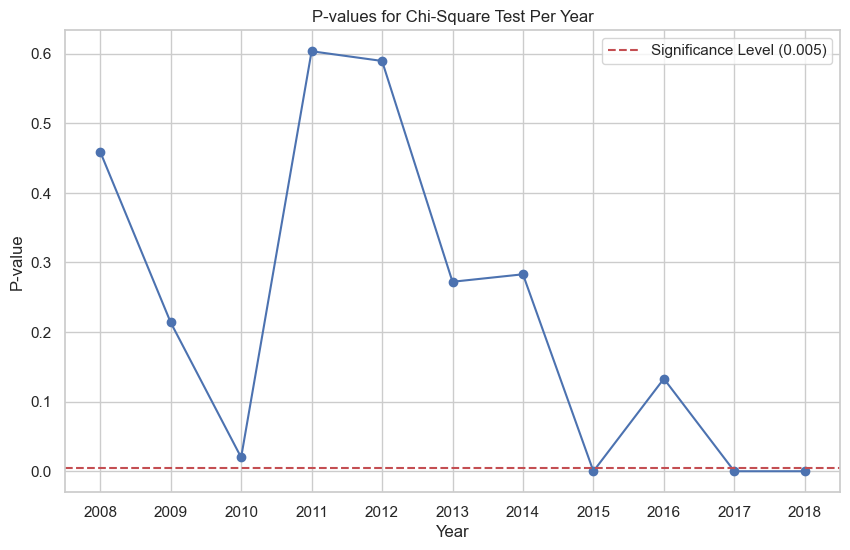

In [ ]:
# Load the data
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['year'] = classified['upload_date'].dt.year
classified['month'] = classified['upload_date'].dt.month

# Remove 2005, 2006, 2007, 2019 as the number of videos is too low (2007 do not contains value for every month so not possible to compute chisquare)
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

# Filter for academic videos
academic = classified[classified['label'] == 'academic']

# Overall distribution for the total sample (across all years)
total = classified.groupby('month').size()

# Initialize storage for p-values
p_values = []

# Perform chi-square test for each year
for year in years:
    # Get monthly counts for academic videos for the current year
    monthly_counts = academic[academic['year'] == year].groupby('month').size()
    
    # Get total scaled distribution for the current year
    total_scaled = total * (monthly_counts.sum() / total.sum())
    
    # Perform chi-square test
    chi_stat, p_value = chisquare(f_obs=monthly_counts, f_exp=total_scaled)
    p_values.append(p_value)
    print(f"Year: {year}, Chi-square Statistic: {chi_stat:.2f}, p-value: {p_value:.4f}")

# Plot p-values to visualize the contribution of each year
plt.figure(figsize=(10, 6))
plt.plot(years, p_values, marker='o')
plt.axhline(0.005, color='r', linestyle='--', label='Significance Level (0.005)')
plt.title('P-values for Chi-Square Test Per Year')
plt.xlabel('Year')
plt.ylabel('P-value')
plt.xticks(years)
plt.legend()
plt.grid('on')
plt.savefig(f"./data/figures/hybs/academic_chisquare_p_value_per_year.png")
plt.show()

# Plotly
fig_plotly = go.Figure()
# Add P-values as a line
fig_plotly.add_trace(go.Scatter(
    x=years,
    y=p_values,
    mode='lines+markers',
    name='P-values'
))
# Add the significance level line
fig_plotly.add_trace(go.Scatter(
    x=years,
    y=[0.005] * len(years),
    mode='lines',
    name='Significance Level (0.005)',
    line=dict(color='red', dash='dash')
))
# Update layout
fig_plotly.update_layout(
    title='P-values for Chi-Square Test Per Year',
    xaxis_title='Year',
    yaxis_title='P-value',
    xaxis=dict(
        tickmode='linear', 
        dtick=1, 
        showgrid=True, 
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='P-value', 
        showgrid=True, 
        gridcolor='lightgrey'
    ),
    legend_title='Legend',
    title_x=0.5,
    template='plotly_white'
)

fig_plotly.write_html(f"./data/figures/hybs/academic_chisquare_p_value_per_year.html")
# fig_plotly.show()

> looking at the p values for each year, the years that contribute to the statistical difference in distribution are the years 2010, 2015, 2017, 2018

### Edutainement videos

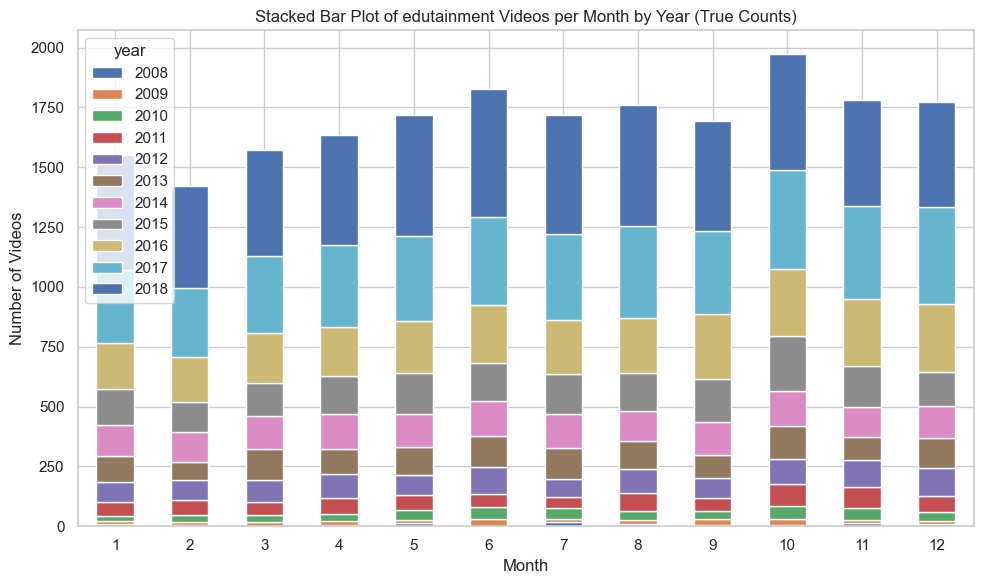

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2007 as the number of videos is too low to make any statistical analysis
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

academic = classified[classified['label'] == 'edutainment or science popularization']

# Remove non-complete years to avoid distortion
monthly_counts = academic.groupby(['year', 'month']).size().unstack(fill_value=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

monthly_counts.T.plot(
    kind='bar', 
    stacked=True, 
    ax=ax
)

ax.set_xlabel('Month')
ax.set_ylabel('Number of Videos')
ax.set_title('Stacked Bar Plot of edutainment Videos per Month by Year (True Counts)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('./data/figures/hybs/edutainment_videos_per_month_by_year.png')
plt.show()

# Plot with Plotly
# Reset the index and ensure 'month' is included
monthly_counts_reset = monthly_counts.T.reset_index().rename(columns={'index': 'month'})
# Convert the DataFrame to a long format for Plotly
monthly_counts_long = monthly_counts_reset.melt(id_vars='month', var_name='year', value_name='count')
fig_plotly = px.bar(
    monthly_counts_long,
    x='month',
    y='count',
    color='year',
    title='Stacked Bar Plot of Edutainment Videos per Month by Year (True Counts)',
    labels={'month': 'Month', 'count': 'Number of Videos', 'year': 'Year'},
    barmode='stack',
    color_discrete_sequence=px.colors.qualitative.Dark2,
)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_indices = list(range(1, 13))  # Assuming months are represented numerically as 1-12

# Update x-axis for month labels
fig_plotly.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=month_indices,
        ticktext=months,
        title='Month'
    ),
    yaxis_title='Number of Videos',
    legend_title='Year',
    title_x=0.5
)

fig_plotly.write_html(f"./data/figures/hybs/edutainment_videos_per_month_by_year.html")
# fig_plotly.show()

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2007 as the number of videos is too low to make any statistical analysis
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

academic = classified[classified['label'] == 'hobby']

# Remove non-complete years to avoid distortion
monthly_counts = academic.groupby('month').size()

# distribution for the whols sample
total = classified.groupby('month').size()
total_scaled = total * (monthly_counts.sum() / total.sum())


chi_stat, p_value = chisquare(f_obs=monthly_counts, f_exp=total_scaled)
print(chi_stat, p_value)


13.011357739410267 0.29258372101700975


> pvalue > 0.05, we cannot reject the null hypothesis

### Hobby videos

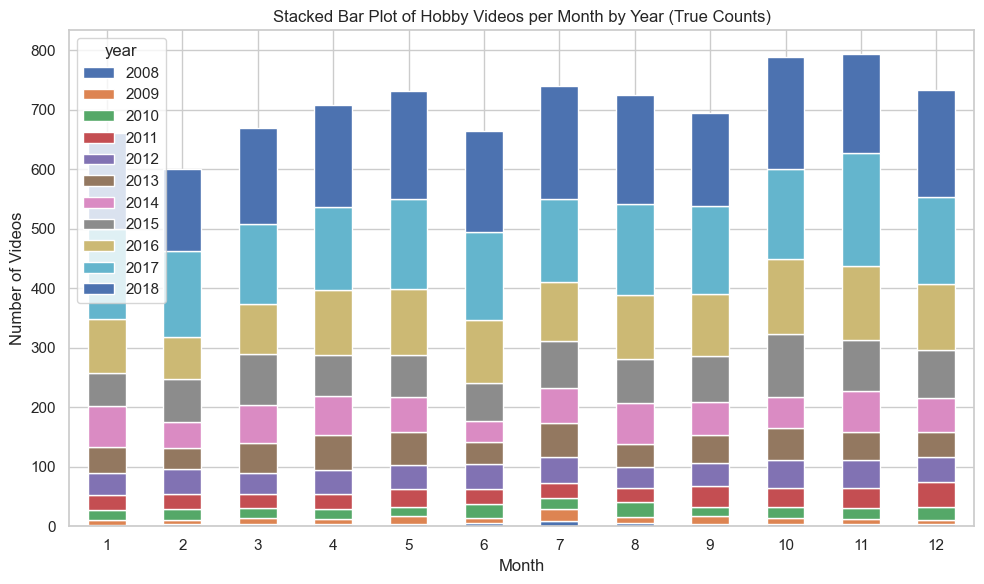

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2007 as the number of videos is too low to make any statistical analysis
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

academic = classified[classified['label'] == 'hobby']

# Remove non-complete years to avoid distortion
monthly_counts = academic.groupby(['year', 'month']).size().unstack(fill_value=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

monthly_counts.T.plot(
    kind='bar', 
    stacked=True, 
    ax=ax
)

ax.set_xlabel('Month')
ax.set_ylabel('Number of Videos')
ax.set_title('Stacked Bar Plot of Hobby Videos per Month by Year (True Counts)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Retrieve academic videos
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['month'] = classified['upload_date'].dt.month
# Remove 2005, 2006, 2007 as the number of videos is too low to make any statistical analysis
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

academic = classified[classified['label'] == 'hobby']

# Remove non-complete years to avoid distortion
monthly_counts = academic.groupby('month').size()

# distribution for the whols sample
total = classified.groupby('month').size()
total_scaled = total * (monthly_counts.sum() / total.sum())


chi_stat, p_value = chisquare(f_obs=monthly_counts, f_exp=total_scaled)
print(chi_stat, p_value)


13.011357739410267 0.29258372101700975


> pvalue > 0.05, we cannot reject the null hypothesis

Year: 2008, Chi-square Statistic: 6.25, p-value: 0.8564
Year: 2009, Chi-square Statistic: 13.01, p-value: 0.2929
Year: 2010, Chi-square Statistic: 5.16, p-value: 0.9231
Year: 2011, Chi-square Statistic: 7.48, p-value: 0.7587
Year: 2012, Chi-square Statistic: 4.19, p-value: 0.9639
Year: 2013, Chi-square Statistic: 15.18, p-value: 0.1744
Year: 2014, Chi-square Statistic: 22.45, p-value: 0.0211
Year: 2015, Chi-square Statistic: 13.72, p-value: 0.2489
Year: 2016, Chi-square Statistic: 9.70, p-value: 0.5579
Year: 2017, Chi-square Statistic: 14.23, p-value: 0.2204
Year: 2018, Chi-square Statistic: 8.46, p-value: 0.6717


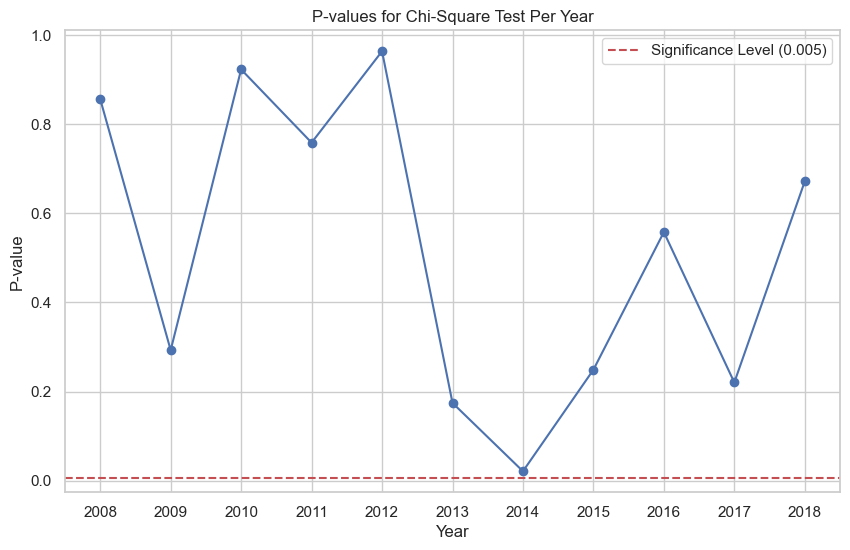

In [ ]:
# Load the data
classified = pd.read_csv(r'data\raw\Education_videos_classified_BART_50000_3_labels.csv')
classified['classified_labels'] = classified['classified_labels'].apply(ast.literal_eval)
classified['label'] = classified['classified_labels'].apply(lambda x: x[0])
classified['upload_date'] = pd.to_datetime(classified['upload_date'])
classified['year'] = classified['upload_date'].dt.year
classified['month'] = classified['upload_date'].dt.month

# Remove 2005, 2006, 2007 as the number of videos is too low
years = np.arange(2008, 2019)
classified = classified[classified['year'].isin(years)]

# Filter for academic videos
academic = classified[classified['label'] == 'hobby']

# Overall distribution for the total sample (across all years)
total = classified.groupby('month').size()

# Initialize storage for p-values
p_values = []

# Perform chi-square test for each year
for year in years:
    # Get monthly counts for academic videos for the current year
    monthly_counts = academic[academic['year'] == year].groupby('month').size()
    
    # Get total scaled distribution for the current year
    total_scaled = total * (monthly_counts.sum() / total.sum())
    
    # Perform chi-square test
    chi_stat, p_value = chisquare(f_obs=monthly_counts, f_exp=total_scaled)
    p_values.append(p_value)
    print(f"Year: {year}, Chi-square Statistic: {chi_stat:.2f}, p-value: {p_value:.4f}")

# Plot p-values to visualize the contribution of each year
plt.figure(figsize=(10, 6))
plt.plot(years, p_values, marker='o')
plt.axhline(0.005, color='r', linestyle='--', label='Significance Level (0.005)')
plt.title('P-values for Chi-Square Test Per Year')
plt.xlabel('Year')
plt.ylabel('P-value')
plt.xticks(years)
plt.legend()
plt.grid('on')
plt.show()


### Time series

In [ ]:
df_ch = pd.read_csv("./data/raw/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_ch = df_ch.dropna()
df_ch["join_date"] = pd.to_datetime(df_ch["join_date"])
df_ch['year'] = df_ch['join_date'].dt.year.astype(int)


df_ts = pd.read_csv("./data/raw/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
df_ts = df_ts.dropna()
df_ts['datetime'] = pd.to_datetime(df_ts['datetime'])
df_ts['year'] = df_ts['datetime'].dt.year
df_ts['month'] = df_ts['datetime'].dt.month

### Specific channel case study

In [ ]:
def plot_stats_channel(channel, year) :
    channel_id = df_ch[df_ch['name_cc'] == channel]['channel'].values.item()
    data = df_ts[df_ts['channel'] == channel_id]
    data = data[data['year'] == year]

    sns.set_theme(style="whitegrid")

    palette = sns.color_palette("deep", n_colors=2)
    views_color = palette[0]
    videos_color = palette[1]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the twin axis first so bars appear behind
    ax2 = ax.twinx()

    # Plot delta_videos as bars on the secondary y-axis first (behind)
    sns.lineplot(data=data, y='videos', x='datetime', color=videos_color, ax=ax2, marker='o', alpha=0.7, legend=False)
    ax2.set_ylabel("Videos", color=videos_color)
    ax2.tick_params(axis='y', labelcolor=videos_color)

    # Plot delta_views as a line on the primary y-axis, in front
    sns.lineplot(data=data, y='delta_views', x='datetime', color=views_color, marker='o', ax=ax, legend=False)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Delta Views", color=views_color)
    ax.tick_params(axis='y', labelcolor=views_color)
    ax.set_title(f"{channel} Delta Views and Delta Videos Over Time for the year {year}")

    # Adjust z-order and transparency so line is on top
    ax.set_zorder(2)
    ax.patch.set_visible(False)

    # Manually create a single combined legend
    line_legend = plt.Line2D([0], [0], color=views_color, marker='o', label='Delta Views')
    bar_legend = plt.Line2D([0], [0], color=videos_color, marker='o', label='Delta Videos')

    ax.legend([line_legend, bar_legend], ['Delta Views', 'Videos'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"./data/figures/hybs/stats_channel_{channel}_{year}.png")
    plt.show()

    # Create the Plotly figure
    fig = go.Figure()
    # Add line plot for Delta Views
    fig.add_trace(go.Scatter(
        x=data['datetime'],
        y=data['delta_views'],
        mode='lines+markers',
        name='Delta Views',
        line=dict(color='rgb(31, 119, 180)'),  # Deep blue color
        marker=dict(color='rgb(31, 119, 180)')
    ))
    # Add line plot for Delta Videos
    fig.add_trace(go.Scatter(
        x=data['datetime'],
        y=data['delta_videos'],
        mode='lines+markers',
        name='Delta Videos',
        yaxis='y2',  # Link to secondary y-axis
        line=dict(color='rgb(255, 127, 14)'),  # Deep orange color
        marker=dict(color='rgb(255, 127, 14)')
    ))
    # Customize the layout with grid
    fig.update_layout(
        title=f'{channel} Delta Views and Delta Videos Over Time for the Year {year}',
        title_x = 0.5,
        xaxis=dict(
            title='Datetime',
            showgrid=True,  # Add grid for the x-axis
            gridcolor='lightgrey',  # Set grid line color
            gridwidth=1  # Set grid line width
        ),
        yaxis=dict(
            title=dict(
                text='Delta Views',
                font=dict(color='rgb(31, 119, 180)')
            ),
            tickfont=dict(color='rgb(31, 119, 180)'),
            showgrid=True,  # Add grid for the primary y-axis
            gridcolor='lightgrey',  # Set grid line color
            gridwidth=1  # Set grid line width
        ),
        yaxis2=dict(
            title=dict(
                text='Delta Videos',
                font=dict(color='rgb(255, 127, 14)')
            ),
            tickfont=dict(color='rgb(255, 127, 14)'),
            overlaying='y',  # Overlay second y-axis
            side='right',  # Place second axis on the right side
            showgrid=False  # No grid for the secondary y-axis to avoid clutter
        ),
        legend=dict(
            title='Metric',
            x=0.5,
            xanchor='center',
            orientation='h'
        ),
        template='plotly_white'
    )
    # Show the plot
    fig.write_html(f"./data/figures/hybs/stats_channel_{channel}_{year}.html")
    # fig.show()

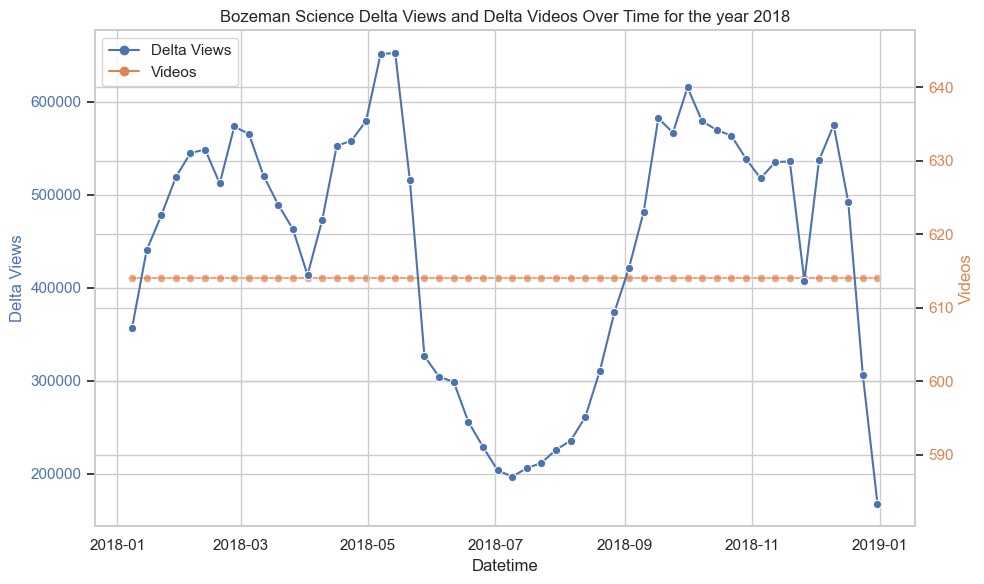

In [ ]:
plot_stats_channel('Bozeman Science', 2018)

# Who is controlling the information or How does the information spread across categories in educational content? 

In [ ]:
topics = {
    "datascience": ["machine learning", "deep learning", "artificial intelligence"],
    "cryptocurrency": ["crypto", "cryptocurrency", "bitcoin", "ethereum", "binance"],
    "ebola": ["ebola"],
    "terrorism": ["bin laden", "Jihadism", "Al-Qaeda"],
    "feminism": ["feminism", "metoo", "#metoo", "me too", "gender equality", "misogyny", "toxic masculinity"]
}

for topic in topics:

    time_series_df = pd.read_csv(os.path.join('data/derivatives/time_series_df', topic + '_time_series.csv'))

    time_series_df.set_index('categories', inplace=True)
    time_series_df.columns = pd.to_datetime(time_series_df.columns, format='%Y-%m')
    time_series_transposed = time_series_df.T
    time_series_transposed.index = pd.to_datetime(time_series_transposed.index, format='%Y-%m')
    agg_time_series_transposed = time_series_transposed.resample('2M').sum() # 
    agg_time_series_df = agg_time_series_transposed.T

    rolling_dtw_results = rolling_dtw_analysis(agg_time_series_df, topic = topic, target_series_name='Education', window_size=6, save_path= 'data/figures/causality/' + topic + '_rolling_dtw')
    granger_results = granger_causality_analysis(agg_time_series_df, target_series_name='Education', max_lag=7, save_path= 'data/figures/causality/' + topic + '_granger')

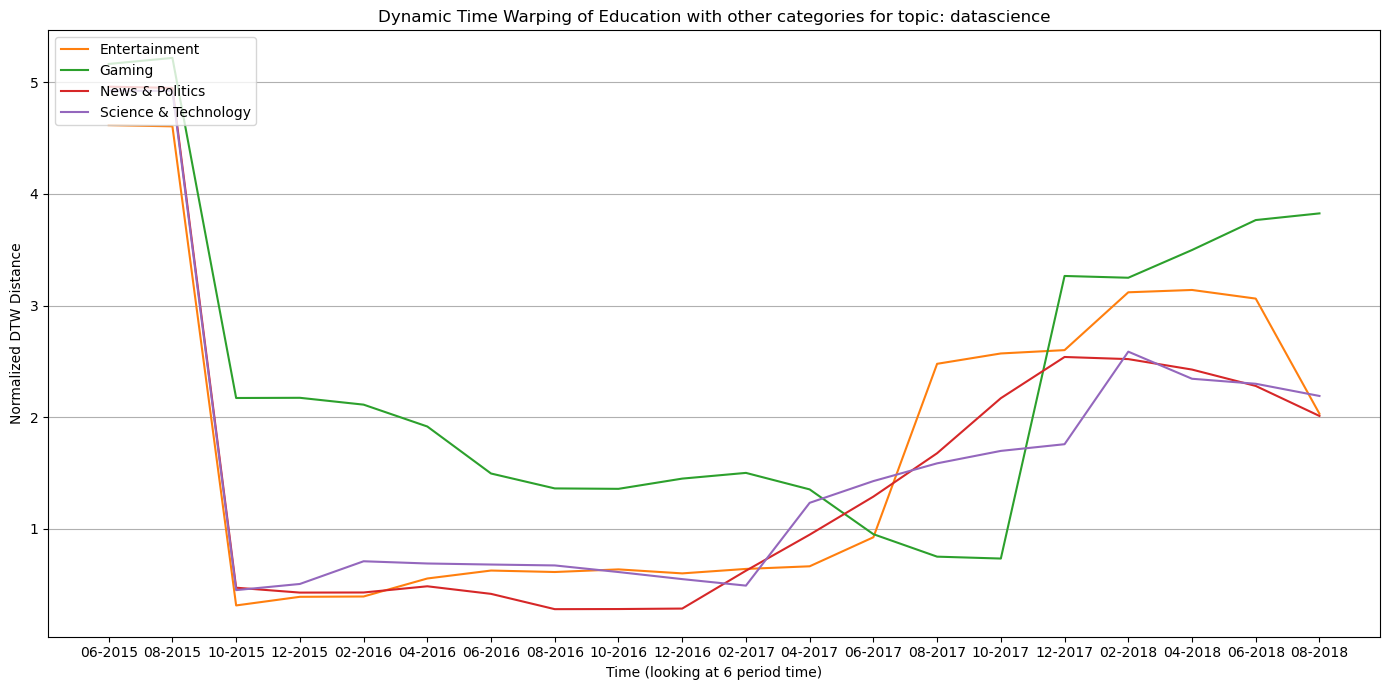

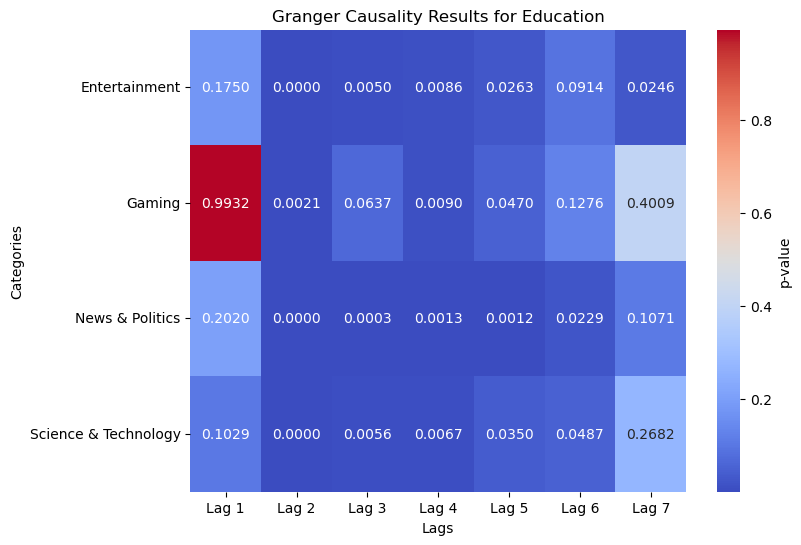

# Which country is the smartest? or  Is there a spatially dependent time evolution in the video’s volume, purpose or content, How does learning content evolve based on the location of creators?


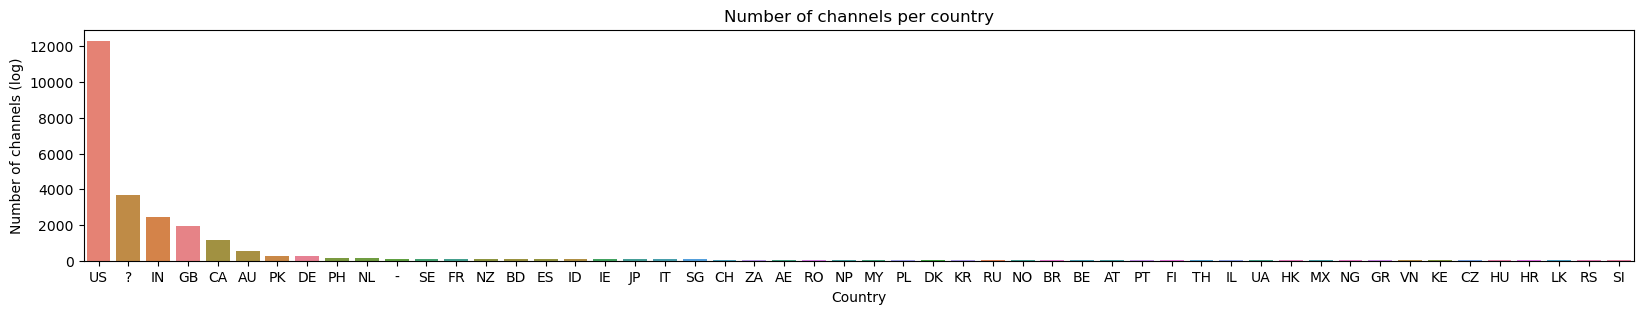

In [ ]:
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col=0, dtype={'country': str, 'channel_id': str})
filter = 20
value_countss = countries['country'].value_counts()
countries['country'] = countries['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)
countries = countries[countries.country != 'Other']

# deleted and no_rec we dont have information so question mark
countries[countries.country == 'deleted'] = '?'
countries[countries.country == 'no_country'] = '-'
countries[countries.country == 'no_rec'] = '?'
countries.country = countries.country.fillna('?') # just in case

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='country', data=countries, order = countries['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
#ax.legend_.remove()
plt.show()

In [ ]:
# Another view but on the filtered data
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

ch_per_country = pd.read_csv(op.join(path_deriv, 'channels_per_country.csv'), index_col=0)
quantiles, bins = pd.qcut(ch_per_country['# channels'], q=40, retbins=True, labels = False,duplicates='drop')
bins = [(int(b), id) for id, b in enumerate(bins) if b != 1.25 and int(b) in [1,5,11,27,35,40, 53,75,96] or b>100 ]
line_color = 'white'#"RebeccaPurple" 'darkgray' 

fig = go.Figure(data=go.Choropleth(
    locations = ch_per_country.country_iso3,
    #z = ch_per_country['# channels'].astype(float),
    z = quantiles,
    text = ch_per_country.country_name,
    customdata=ch_per_country['# channels'],
    colorscale = 'Spectral',#'Blues',
    colorbar=dict(
        tickvals=[str(b) for id, b in bins],
        ticktext=[str(id) for id, b in bins],  # Label quantiles
        x = 1,
        tickfont=dict(size=8.5)
    ),
    showscale=True,
    hovertemplate="<b>%{text}</b><extra>%{customdata:,.0f} channels</extra>",
    autocolorscale=False,
    reversescale=True,
    marker_line_color=line_color,
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = '# channels',
    
))

fig.update_geos(
        showframe=True,
        showcoastlines=True, coastlinecolor=line_color, coastlinewidth=0.8,
        showocean=True, oceancolor="LightBlue",
        showlakes=False, lakecolor="Blue",
        showrivers=False, rivercolor="Blue",
        showland=True, landcolor="#fff0db",
        projection_type='equirectangular'
    )

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig, 'country_channel.html'), auto_open=True)

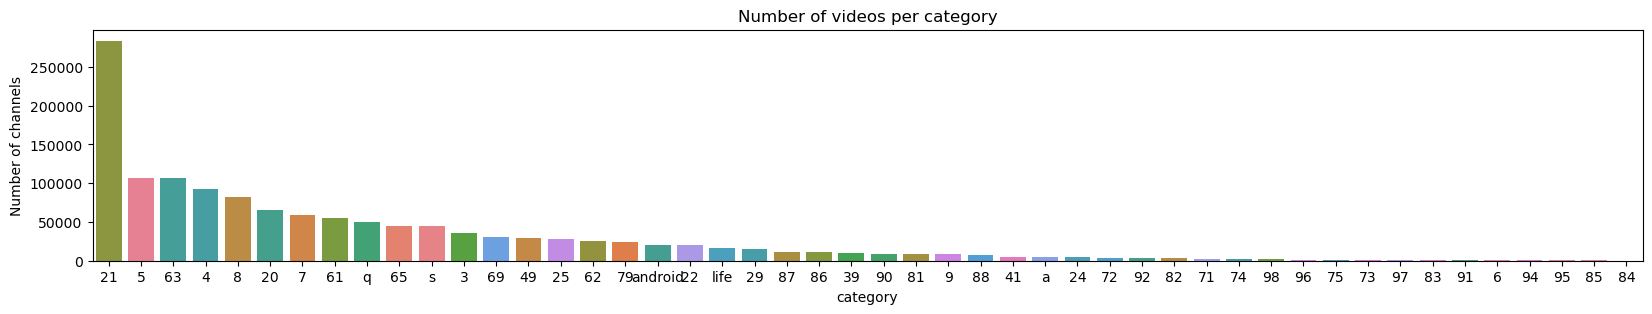

In [ ]:
edu = pd.DataFrame()
for i in range(N_BATCHES):
    batch = pd.read_csv(path_edu.format(i), index_col=0).drop(columns = ['description', 'crawl_date', 'title', 'tags'])
    edu = pd.concat([edu, batch])
    del batch

edu = edu.rename(columns={'channel_id': 'channel', 'categories': 'vid_category'})
classif = pd.read_csv(path_classified)[['display_id', 'category']]
edu = edu.merge(classif, on='display_id', how='left')
to_plot = edu[edu.category != 'unclass'].copy().drop(columns = ['text'])

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='category', data=to_plot, order = to_plot.category.value_counts().index, hue = 'category', ax=ax)
ax.set_title('Number of videos per category')
ax.set_xlabel('category')
ax.set_ylabel('Number of channels')
plt.show()

## Countries results

In [ ]:
country_category = pd.read_csv(op.join(path_deriv, 'country_category.csv'), index_col=0)
country_category = edu.groupby(['country', 'category']).count().reset_index()[['country', 'category', 'channel']].rename(columns = {'channel': '# videos'})
country_category['subcategory'] = country_category.category.apply(lambda x: content_categories[x].capitalize())
country_category['country_name'] = country_category.country.apply(get_country_fullname)
fig = px.sunburst(
    country_category,
    custom_data='subcategory',
    path=['country_name', 'category'],  # Specify the hierarchy
    values='# videos',  # Values determine the size of each slice
    #title="Sunburst Plot of Country and Category"
)
fig.update_traces(
    hovertemplate="<b>%{label}: %{customdata}</b><br># videos: %{value}"
)

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig,'country_sunburst.html'), auto_open=True)

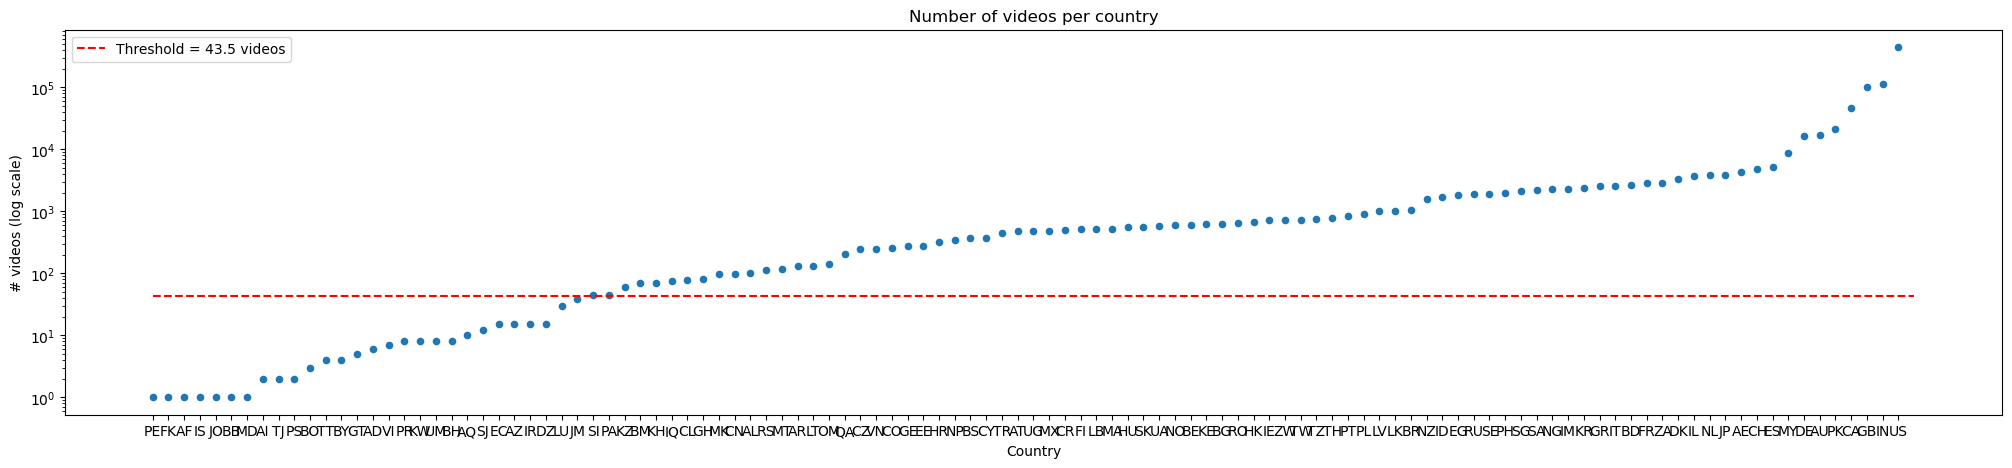

In [ ]:
# for numerical data
numericals = pd.read_csv(op.join(path_deriv, 'country_numericals.csv'), index_col=0)
quantile_threshold = numericals['# videos'].quantile(0.25)

fig, ax = plt.subplots(1, 1, figsize=(25,5))
numericals.sort_values(by = '# videos').plot(kind='scatter', y='# videos', x='country', logy=True, figsize=(25,5), title='Number of videos per country', ax=ax)
ax.plot([0, len(numericals)], [quantile_threshold, quantile_threshold], 'r--', label=f'Threshold = {quantile_threshold} videos')
ax.set_xlabel('Country')
ax.set_ylabel('# videos (log scale)')
plt.legend()
# filter at 25% quantile
numericals = numericals[numericals['# videos'] > quantile_threshold]

In [ ]:

numericals['like_per_view_per_video'] = numericals['like_per_view'] / numericals['# videos']
numericals['dislike_per_view_per_video'] = numericals['dislike_per_view'] / numericals['# videos']
numericals['like_per_vid'] = numericals['like_count'] / numericals['# videos']
numericals['dislike_per_vid'] = numericals['dislike_count'] / numericals['# videos']
numericals['country_name'] = numericals.country.apply(get_country_fullname)
numericals['Region'] = numericals.country_name.apply(get_region)
numericals.Region = numericals.Region.apply(lambda x: 'Oceania' if x == 'Australia and New Zealand' else x)

In [ ]:
numericals['color'] = numericals['region'].map(custom_color_map)

fig = px.scatter(numericals, x="like_per_vid", y="dislike_per_vid",
	         size="view_count", color="Region",
                 hover_name="country_name", 
                 color_discrete_map = custom_color_map,
                 log_x = False, log_y=False, 
                 custom_data=['country_name', '# videos'],
                 size_max=50,
                 text="country",
    )

fig.update_layout(
    xaxis=dict(title="Likes per video",tickformat=".1s"),
    yaxis=dict(title="Dislikes per video",tickformat=".1s"),
    #plot_bgcolor="lightgray", 
    paper_bgcolor="white", 
    showlegend=True ,
    legend=dict(font=dict(size=11)),
)
fig.update_traces( # change text inside bubbles
    textfont=dict(size=12, color='white'),
    textposition='middle center',
    hovertemplate="<b>%{customdata[0]}</b><br> Likes per video: %{x:.0f} <br> Dislikes per video: %{y:.0f}<br> Median Views: %{marker.size:.0f} <br> # videos: %{customdata[1]:,.0f}",
    hoverlabel=dict(font=dict(size=12)),
    
)

lines = [
    {"slope": 0.5, "intercept": 0, "name": "1/2"},
    {"slope": 0.33, "intercept": 0, "name": "1/3"}
]

# Add lines to the plot
for line in lines:
    x_vals = np.array([0, 10])  # Define the x-range for the line
    y_vals = line["slope"] * x_vals + line["intercept"]  # Calculate y = mx + b
    fig.add_trace(
        go.Scatter(
            x=x_vals, 
            y=y_vals, 
            mode="lines", 
            name=line["name"], 
            line=dict(dash="dash")  # Optional: make the lines dashed
        )
    )
    
# fig.write_html(op.join(path_country_fig,'country_likes_dislikes.html'), auto_open=True)
fig.show()

In [ ]:
# compute like dislike ratio
numericals['dislike_like_ratio'] = numericals['dislike_count'] / numericals['like_count']
numericals.sort_values(by='dislike_like_ratio', ascending=True)[['country_name', 'dislike_like_ratio']]
numericals[numericals.country.isin(['AT', 'JP', 'TW', 'RO', 'RS', 'LU', 'VN','KR'])][['country_name',  'dislike_like_ratio']].sort_values(by='dislike_like_ratio', ascending=False)

,country_name,dislike_like_ratio
120,Viet Nam,0.378424
95,Serbia,0.357258
70,Luxembourg,0.294357
64,"Korea, Republic of",0.260530
61,Japan,0.083739
111,"Taiwan, Province of China",0.041106
8,Austria,0.035502
94,Romania,0.031121
